## TP Integrador - Series de Tiempo

#### Alumno: Lucas Rivela
#### Cohorte: 5
#### Profesores: Magdalena Bouza y Carlos Romano

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa as tsa
import torch
from datetime import datetime
from scipy import stats, signal
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, acf, kpss
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
pd.set_option('display.max_columns', None)

##### Entrega 1

- Graficar una serie a partir de un dataset relevante. Describir observaciones.
- Descomponer una serie de tiempo usando el modelo aditivo de cuatro componentes. (statsmodel -> decompose en 4 partes: tendencia, cíclica, estacional y ruido)
- Extraer la tendencia y ajustar un modelo determinístico. Explicar su relación con el contexto. Obtener conclusiones acerca de la validez del modelo.
- Evaluar si la serie original es estacionaria. Aplicar transformaciones (preprocesamiento), graficar autocorrelación, autocorrelación parcial y extraer conclusiones.

##### Entrega 2

- Ajustar distintos modelos (S)ARIMA. Extraer orden, parámetros, coeficientes numéricos y análisis de la bondad del modelo.
- Ajustar y predecir usando redes LSTM. Comparar con SARIMA.
- Realizar análisis espectral de la serie original. Hallar las frecuencias principales y comparar con las componentes cíclica y estacioal usando la descomposición.

In [2]:
df_sube21 = pd.read_csv('./dat-ab-usos-2021.csv')
df_sube21.head()

DIA_TRANSPORTE                                     NOMBRE_EMPRESA  \
0     2021-01-01                                 EMPRESA BATAN S.A.   
1     2021-01-01               COMPAÑIA  DE TRANSPORTE VECINAL S.A.   
2     2021-01-01           EMPRESA DE TRANSPORTE PERALTA RAMOS SACI   
3     2021-01-01  AUTOBUSES BUENOS AIRES S.R.L. – TRANSPORTE LAR...   
4     2021-01-01                                      EL URBANO SRL   

              LINEA AMBA TIPO_TRANSPORTE JURISDICCION     PROVINCIA  \
0  BS_AS_LINEA 715M   NO       COLECTIVO    MUNICIPAL  BUENOS AIRES   
1   BS_AS_LINEA_326   SI       COLECTIVO   PROVINCIAL  BUENOS AIRES   
2   BS_AS_LINEA_512   NO       COLECTIVO    MUNICIPAL  BUENOS AIRES   
3   BS_AS_LINEA_514   SI       COLECTIVO    MUNICIPAL  BUENOS AIRES   
4   BS_AS_LINEA_522   SI       COLECTIVO    MUNICIPAL  BUENOS AIRES   

            MUNICIPIO  CANTIDAD DATO_PRELIMINAR  
0  GENERAL PUEYRREDON      1466              NO  
1                  SN       625              NO  
2  GENERAL PUEYRREDON      1119              NO  
3     ALMIRANTE BROWN      2813              NO  
4               LANUS        99              NO

In [3]:
df_sube22 = pd.read_csv('./dat-ab-usos-2022.csv')
df_sube22.head()

DIA_TRANSPORTE                                     NOMBRE_EMPRESA  \
0     2022-01-01  MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...   
1     2022-01-01  MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...   
2     2022-01-01                                 EMPRESA BATAN S.A.   
3     2022-01-01               COMPAÑIA  DE TRANSPORTE VECINAL S.A.   
4     2022-01-01           EMPRESA DE TRANSPORTE PERALTA RAMOS SACI   

              LINEA AMBA TIPO_TRANSPORTE JURISDICCION     PROVINCIA  \
0                 1   SI       COLECTIVO    MUNICIPAL  BUENOS AIRES   
1                2B   SI       COLECTIVO    MUNICIPAL  BUENOS AIRES   
2  BS_AS_LINEA 715M   NO       COLECTIVO    MUNICIPAL  BUENOS AIRES   
3   BS_AS_LINEA_326   SI       COLECTIVO   PROVINCIAL  BUENOS AIRES   
4   BS_AS_LINEA_512   NO       COLECTIVO    MUNICIPAL  BUENOS AIRES   

            MUNICIPIO  CANTIDAD DATO_PRELIMINAR  
0            MERCEDES        10              NO  
1            MERCEDES        19              NO  
2  GENERAL PUEYRREDON      1418              NO  
3                  SN       675              NO  
4  GENERAL PUEYRREDON      1906              NO

##### Me fijo si hay Nulls

In [5]:
df_sube21.isna().sum()

DIA_TRANSPORTE        0
NOMBRE_EMPRESA        0
LINEA                 0
AMBA                  0
TIPO_TRANSPORTE       0
JURISDICCION       2974
PROVINCIA          2974
MUNICIPIO          2974
CANTIDAD              0
DATO_PRELIMINAR       0
dtype: int64

In [6]:
df_sube22.isna().sum()

DIA_TRANSPORTE        0
NOMBRE_EMPRESA        0
LINEA                 0
AMBA                  0
TIPO_TRANSPORTE       0
JURISDICCION       1731
PROVINCIA          1731
MUNICIPIO          1731
CANTIDAD              0
DATO_PRELIMINAR       0
dtype: int64

En ambos casos vemos nulls para las columnas Jurisdiccion, Provincia y Municipio. De todos modos serán ignoradas para el análisis de la serie.

In [7]:
df_sube21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410644 entries, 0 to 410643
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DIA_TRANSPORTE   410644 non-null  object
 1   NOMBRE_EMPRESA   410644 non-null  object
 2   LINEA            410644 non-null  object
 3   AMBA             410644 non-null  object
 4   TIPO_TRANSPORTE  410644 non-null  object
 5   JURISDICCION     407670 non-null  object
 6   PROVINCIA        407670 non-null  object
 7   MUNICIPIO        407670 non-null  object
 8   CANTIDAD         410644 non-null  int64 
 9   DATO_PRELIMINAR  410644 non-null  object
dtypes: int64(1), object(9)
memory usage: 31.3+ MB


In [8]:
df_sube22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291462 entries, 0 to 291461
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DIA_TRANSPORTE   291462 non-null  object
 1   NOMBRE_EMPRESA   291462 non-null  object
 2   LINEA            291462 non-null  object
 3   AMBA             291462 non-null  object
 4   TIPO_TRANSPORTE  291462 non-null  object
 5   JURISDICCION     289731 non-null  object
 6   PROVINCIA        289731 non-null  object
 7   MUNICIPIO        289731 non-null  object
 8   CANTIDAD         291462 non-null  int64 
 9   DATO_PRELIMINAR  291462 non-null  object
dtypes: int64(1), object(9)
memory usage: 22.2+ MB


In [9]:
df21 = df_sube21.drop(columns=['NOMBRE_EMPRESA', 'LINEA', 'AMBA', 'TIPO_TRANSPORTE', 'JURISDICCION', 'PROVINCIA', 'MUNICIPIO', 'DATO_PRELIMINAR'], axis=1)
df21.head()

DIA_TRANSPORTE  CANTIDAD
0     2021-01-01      1466
1     2021-01-01       625
2     2021-01-01      1119
3     2021-01-01      2813
4     2021-01-01        99

In [10]:
df22 = df_sube22.drop(columns=['NOMBRE_EMPRESA', 'LINEA', 'AMBA', 'TIPO_TRANSPORTE', 'JURISDICCION', 'PROVINCIA', 'MUNICIPIO', 'DATO_PRELIMINAR'], axis=1)
df22.head()

DIA_TRANSPORTE  CANTIDAD
0     2022-01-01        10
1     2022-01-01        19
2     2022-01-01      1418
3     2022-01-01       675
4     2022-01-01      1906

In [11]:
df21['DIA_TRANSPORTE'] = pd.to_datetime(df21['DIA_TRANSPORTE'])
df22['DIA_TRANSPORTE'] = pd.to_datetime(df22['DIA_TRANSPORTE'])

In [12]:
df = pd.concat([df21, df22], ignore_index=True)
df.head()

DIA_TRANSPORTE  CANTIDAD
0     2021-01-01      1466
1     2021-01-01       625
2     2021-01-01      1119
3     2021-01-01      2813
4     2021-01-01        99

In [13]:
df.tail()

DIA_TRANSPORTE  CANTIDAD
702101     2022-09-02         5
702102     2022-09-02       662
702103     2022-09-02      1303
702104     2022-09-02       393
702105     2022-09-02       730

In [14]:
serie = df.groupby(['DIA_TRANSPORTE']).sum()

In [15]:
serie.head()

CANTIDAD
DIA_TRANSPORTE          
2021-01-01       1178259
2021-01-02       3626837
2021-01-03       2349540
2021-01-04       6352559
2021-01-05       6591339

In [16]:
serie.tail()

CANTIDAD
DIA_TRANSPORTE          
2022-08-29      12862451
2022-08-30      13239561
2022-08-31      13239636
2022-09-01      12483866
2022-09-02       6981899

In [17]:
serie.reset_index(inplace=True)

##### Trabajo con la Serie

In [18]:
serie['Year'] = pd.DatetimeIndex(serie['DIA_TRANSPORTE']).year
serie['Month'] = pd.DatetimeIndex(serie['DIA_TRANSPORTE']).month

serie.head()

DIA_TRANSPORTE  CANTIDAD  Year  Month
0     2021-01-01   1178259  2021      1
1     2021-01-02   3626837  2021      1
2     2021-01-03   2349540  2021      1
3     2021-01-04   6352559  2021      1
4     2021-01-05   6591339  2021      1

In [19]:
serie.tail()

DIA_TRANSPORTE  CANTIDAD  Year  Month
605     2022-08-29  12862451  2022      8
606     2022-08-30  13239561  2022      8
607     2022-08-31  13239636  2022      8
608     2022-09-01  12483866  2022      9
609     2022-09-02   6981899  2022      9

Text(0.5, 1.0, 'Viajes por dia')

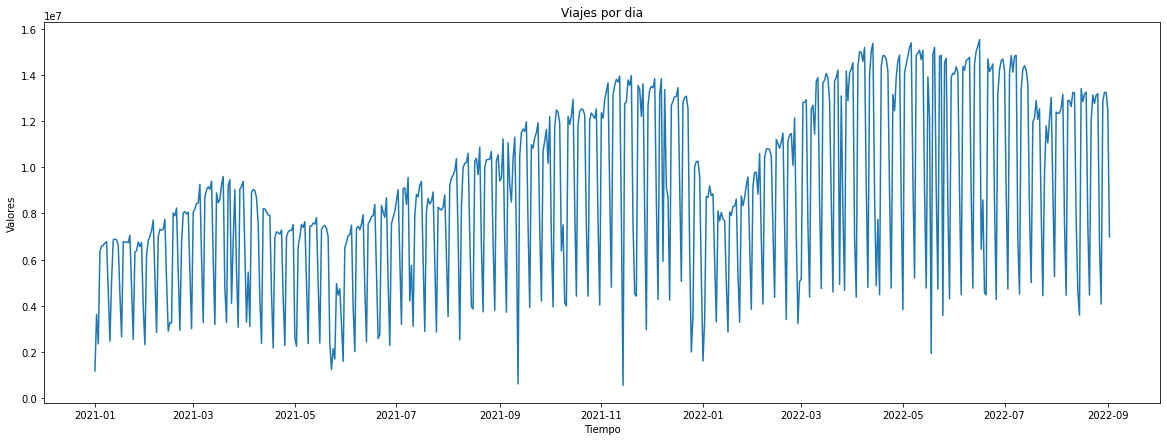

In [20]:
plt.figure(figsize=(20,7))
sns.lineplot(data=serie, x='DIA_TRANSPORTE', y='CANTIDAD')
plt.xlabel('Tiempo')
plt.ylabel('Valores')
plt.title('Viajes por dia')

En esta gráfica se pueden ver la cantidad de transacciones de SUBE por día desde Enero de 2021 hasta Octubre de 2022.

Si tomamos la serie por cada año, parecería tener una tendencia creciente hacia el final de cada uno. Esto nos podría estar indicando que hay una especie de estacionalidad anual.

Por otro lado, también se pueden ver una especie de "serrucho" que son la cantidad de viajes cayendo en los fines de semana. Esto nos podría estar indicando una estacionalidad semanal.

In [21]:
por_mes = serie.groupby(['Year', 'Month']).sum()
por_mes.reset_index(inplace=True)
por_mes

Year  Month   CANTIDAD
0   2021      1  167095783
1   2021      2  174180306
2   2021      3  233999339
3   2021      4  193512137
4   2021      5  163014875
5   2021      6  192962361
6   2021      7  228316341
7   2021      8  260555303
8   2021      9  279104810
9   2021     10  301885025
10  2021     11  327904779
11  2021     12  310467470
12  2022      1  219746789
13  2022      2  253014089
14  2022      3  342453762
15  2022      4  348180758
16  2022      5  355904410
17  2022      6  353580411
18  2022      7  340864406
19  2022      8  334810387
20  2022      9   19465765

Text(0.5, 1.0, 'Comparacion viajes por mes 2021 vs 2022')

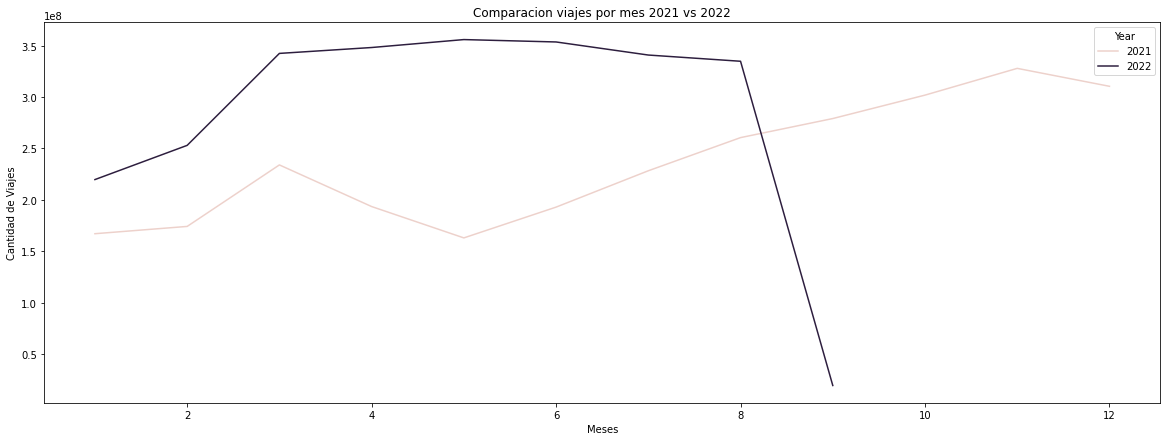

In [22]:
plt.figure(figsize=(20,7))
sns.lineplot(data=por_mes, x='Month', y='CANTIDAD', hue='Year')
plt.xlabel('Meses')
plt.ylabel('Cantidad de Viajes')
plt.title('Comparacion viajes por mes 2021 vs 2022')

En este gráfico podemos ver que en 2022 se hicieron más viajes en todos los meses. 2022 baja en septiembre porque el mes no estaba cerrado al momento de hacer los gráficos. Igualmente era lo esperable ya que 2021 todavía es un año muy pegado al 2020 de pandemia.

2022 parece tener mucha mayor estabilidad en la cantidad de viajes por mes comparado a 2021. Por otro lado en Mayo de 2021 se nota una caída en la cantidad de viajes por el rebrote de Covid que hubo.

También se puede ver que Enero y Febrero son los meses de menor cantidad de viajes (probablemente por las vacaciones).

In [23]:
serie["DayName"] = serie['DIA_TRANSPORTE'].dt.day_name()
serie["WeekDay"] = serie['DIA_TRANSPORTE'].dt.weekday

serie.head()

DIA_TRANSPORTE  CANTIDAD  Year  Month   DayName  WeekDay
0     2021-01-01   1178259  2021      1    Friday        4
1     2021-01-02   3626837  2021      1  Saturday        5
2     2021-01-03   2349540  2021      1    Sunday        6
3     2021-01-04   6352559  2021      1    Monday        0
4     2021-01-05   6591339  2021      1   Tuesday        1

In [24]:
por_dayofweek = serie.groupby(['Year', 'Month', 'WeekDay', 'DayName']).sum()
por_dayofweek.reset_index(inplace=True)
por_dayofweek.sort_values(['Year', 'Month', 'WeekDay'], ascending=[True, True, True])
por_dayofweek

Year  Month  WeekDay    DayName  CANTIDAD
0    2021      1        0     Monday  24550817
1    2021      1        1    Tuesday  26568103
2    2021      1        2  Wednesday  27040631
3    2021      1        3   Thursday  26857365
4    2021      1        4     Friday  28369544
..    ...    ...      ...        ...       ...
137  2022      8        4     Friday  52836199
138  2022      8        5   Saturday  29700767
139  2022      8        6     Sunday  17595340
140  2022      9        3   Thursday  12483866
141  2022      9        4     Friday   6981899

[142 rows x 5 columns]

Text(0.5, 1.0, 'Comparacion viajes por dia de la semana 2021 vs 2022')

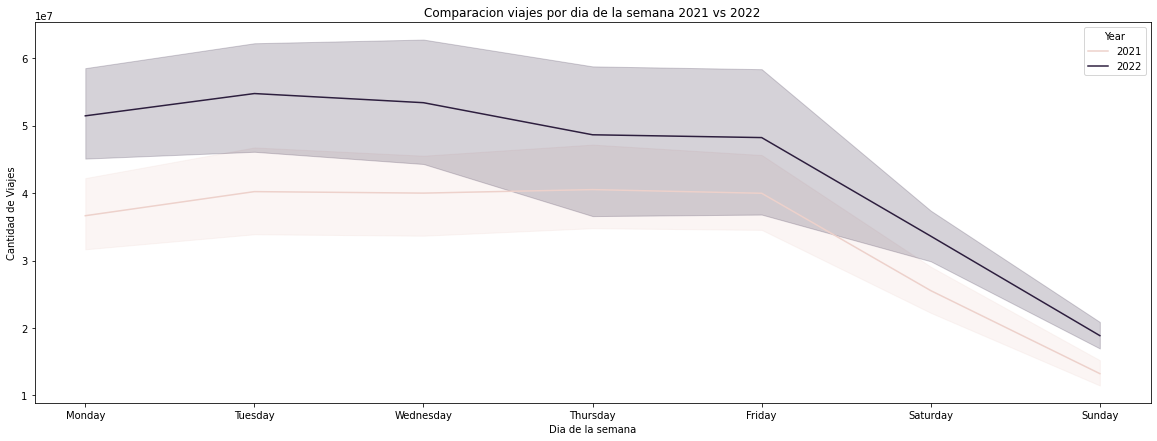

In [25]:
plt.figure(figsize=(20,7))
sns.lineplot(data=por_dayofweek, x='DayName', y='CANTIDAD', hue='Year')
plt.xlabel('Dia de la semana')
plt.ylabel('Cantidad de Viajes')
plt.title('Comparacion viajes por dia de la semana 2021 vs 2022')

En este otro gráfico vemos agrupados los viajes por día de la semana. Se puede ver como la cantidad de viajes cae hacia el final de la semana y se reduce mucho los fines de semana. Como en el gráfico anterior, 2022 le gana en todos los días a 2021.

<AxesSubplot:xlabel='CANTIDAD', ylabel='Count'>

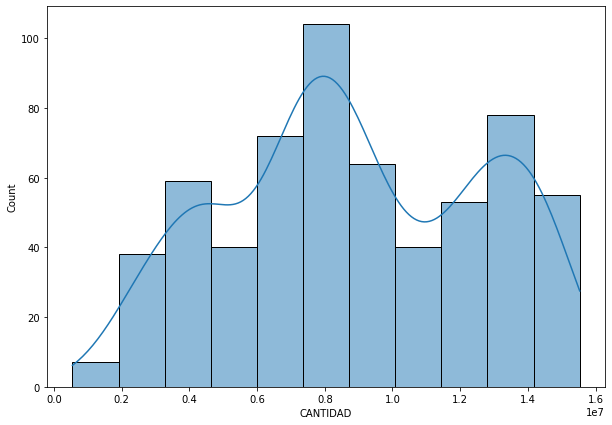

In [26]:
plt.figure(figsize=(10,7))
sns.histplot(data=serie, x='CANTIDAD', kde=True)

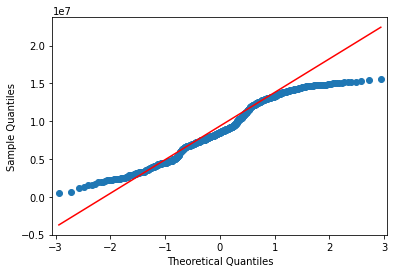

In [27]:
sm.qqplot(serie['CANTIDAD'], line='q')
plt.show()

<AxesSubplot:xlabel='CANTIDAD'>

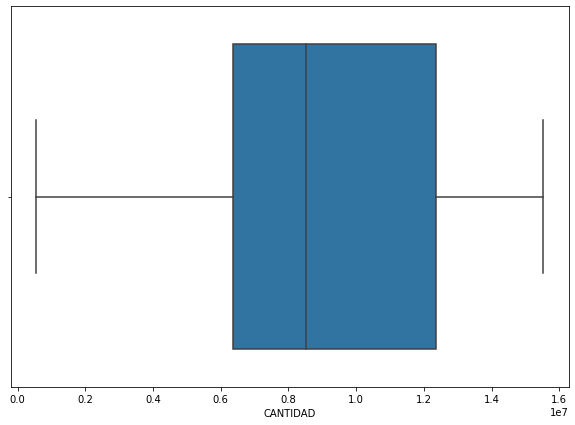

In [28]:
plt.figure(figsize=(10,7))
sns.boxplot(data=serie, x='CANTIDAD')

##### Descompocisión usando el modelo aditivo de 4 componentes

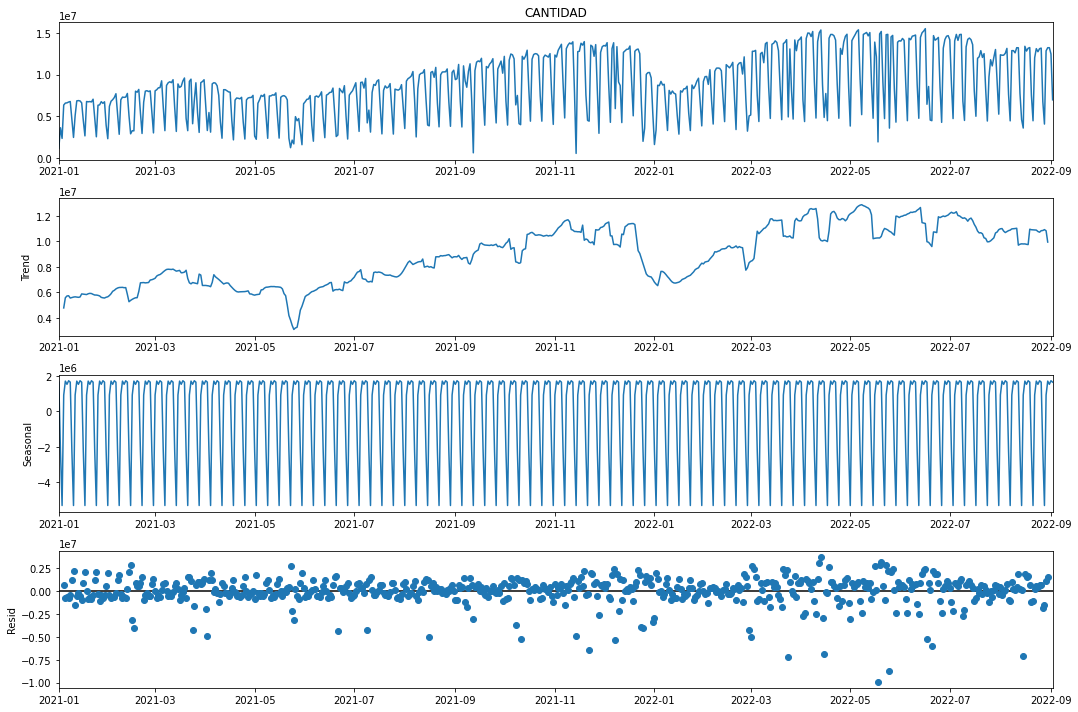

In [29]:

decomp = serie[["DIA_TRANSPORTE","CANTIDAD"]].copy()
decomp["DIA_TRANSPORTE"] = pd.to_datetime(decomp["DIA_TRANSPORTE"])
decomp = decomp.set_index("DIA_TRANSPORTE")
additive = sm.tsa.seasonal_decompose(decomp.CANTIDAD, model='additive')
fig = additive.plot()
fig.set_size_inches(15,10)
fig.tight_layout()
plt.show()

##### Extracción de Tendencia

In [30]:
def lineal(x, a, b):
    return a * x + b

In [31]:
def cuadratica(x, a, b, c):
    return a * x**2 + b * x + c

In [32]:
def cubica(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

In [33]:
def cuartica(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

In [34]:
def sine(x, a, b, c, d):
    return a * np.sin(b * x - c) + d

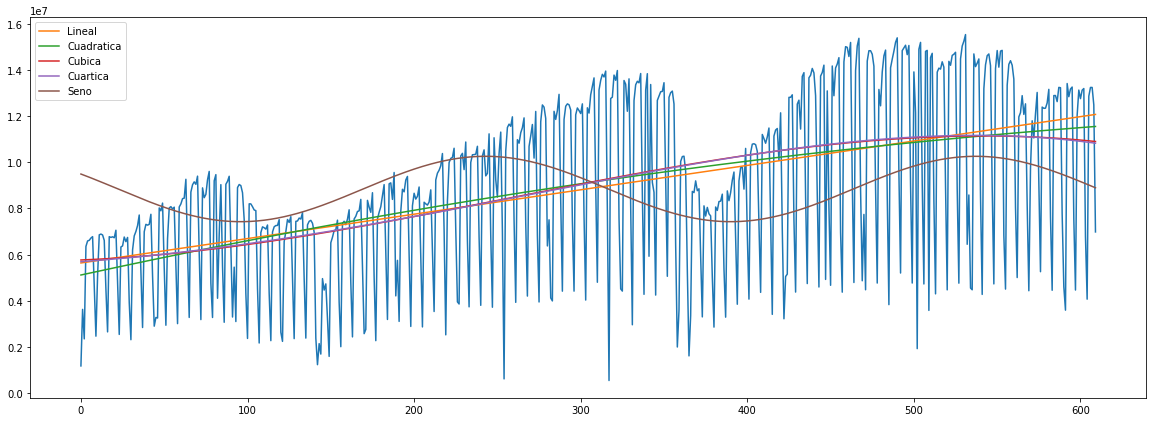

In [35]:
x = np.arange(0, len(serie["DIA_TRANSPORTE"]), 1)
y = serie["CANTIDAD"]

poptl, _ = curve_fit(lineal, x, y)
a, b = poptl
y_lineL = lineal(x, a, b)

popt2 , _ = curve_fit(cuadratica, x, y)
a, b, c = popt2
y_line2 = cuadratica(x, a, b, c)

popt3, _ = curve_fit(cubica, x, y)
a, b, c, d = popt3
y_line3 = cubica(x, a, b, c, d)

popt4, _ = curve_fit(cuartica, x, y)
a, b, c, d, e = popt4
y_line4 = cuartica(x, a, b, c, d, e)

popts, _ = curve_fit(sine, x, y)
a, b, c, d = popts
y_lineS = sine(x, a, b, c, d)

plt.figure(figsize=(20,7))
plt.plot(x,y)
plt.plot(x, y_lineL, label='Lineal')
plt.plot(x, y_line2, label='Cuadratica')
plt.plot(x, y_line3, label='Cubica')
plt.plot(x, y_line4, label='Cuartica')
plt.plot(x, y_lineS, label='Seno')
plt.legend()

De todas las curvas que se ajustaron, parecería que la que mejor ajusta es la cubica. 

##### Preprocesamiento

BoxCox

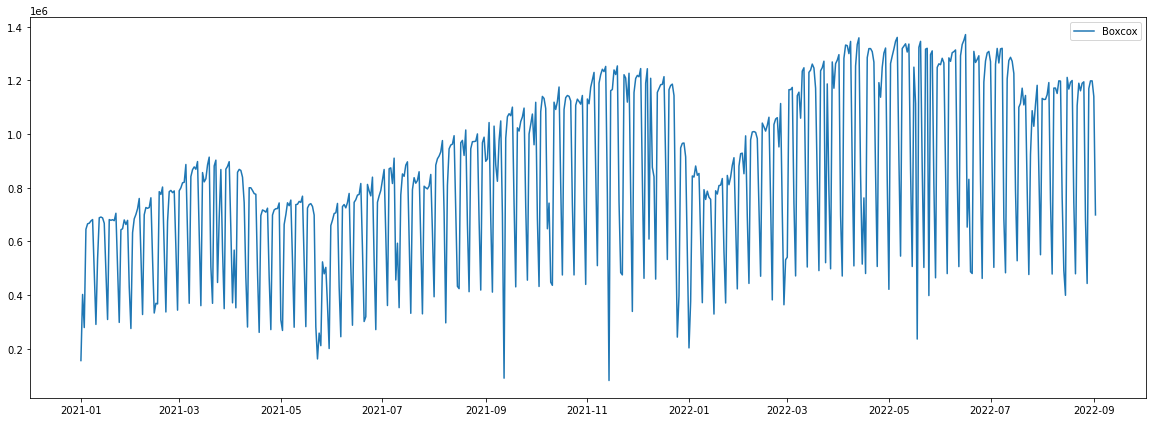

In [36]:
yt, _ = stats.boxcox(y)
plt.figure(figsize=(20,7))
plt.plot(serie["DIA_TRANSPORTE"],yt, label='Boxcox')
plt.legend()

Box Cox le bajó un orden de magnitud.

Logaritmica

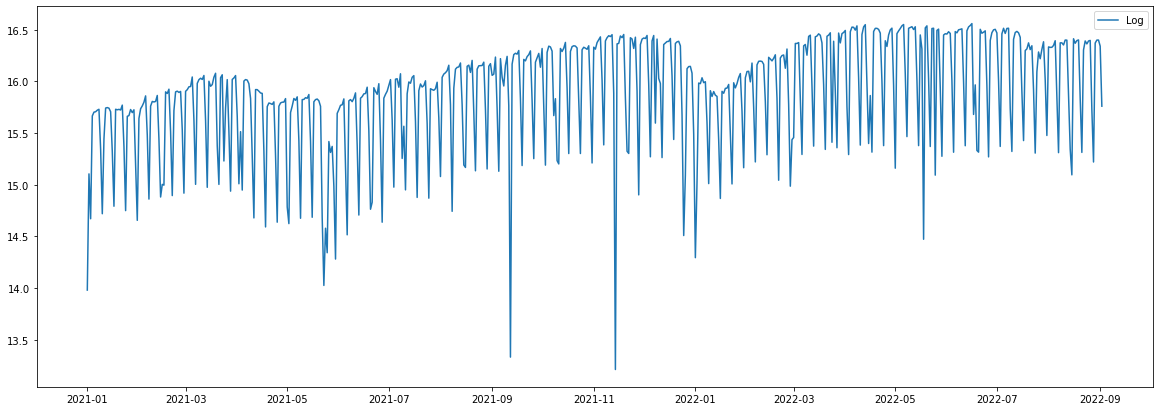

In [37]:
yt = np.log(y)
plt.figure(figsize=(20,7))
plt.plot(serie["DIA_TRANSPORTE"],yt, label='Log')
plt.legend()

Potencia

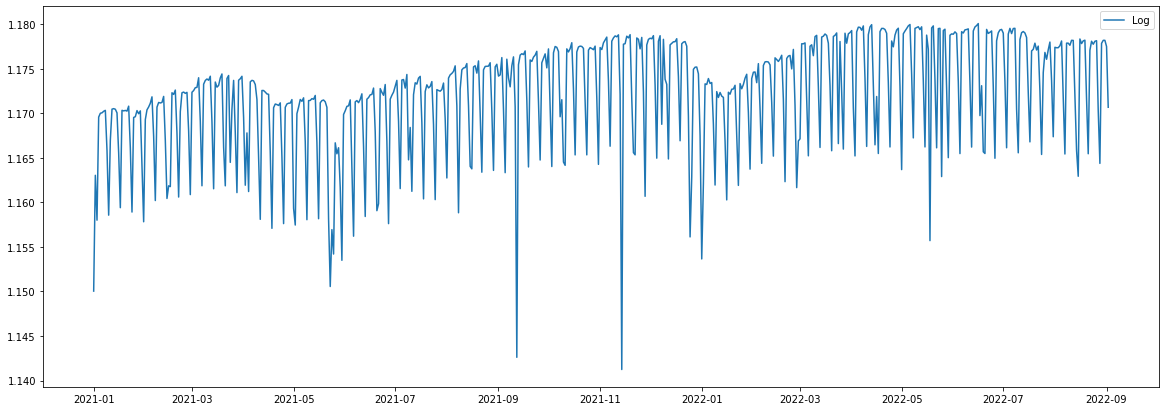

In [38]:
yt = np.power(y, 0.01)
plt.figure(figsize=(20,7))
plt.plot(serie["DIA_TRANSPORTE"],yt, label='Log')
plt.legend()

Diferenciacion

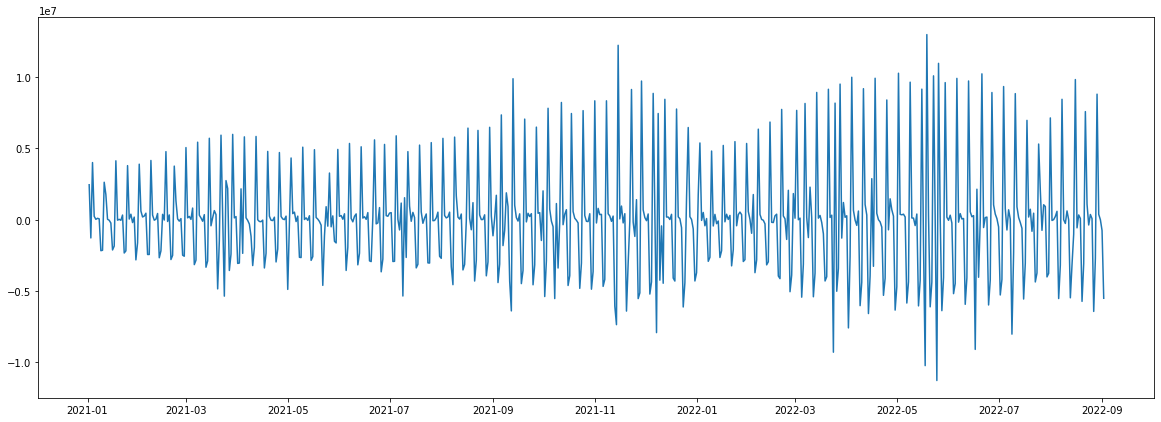

In [39]:
diff = serie[["DIA_TRANSPORTE", "CANTIDAD"]].copy()
diff = diff.set_index("DIA_TRANSPORTE")
diff = diff.diff()
plt.figure(figsize=(20,7))
plt.plot(diff.index, diff["CANTIDAD"])

##### Estacionariedad

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


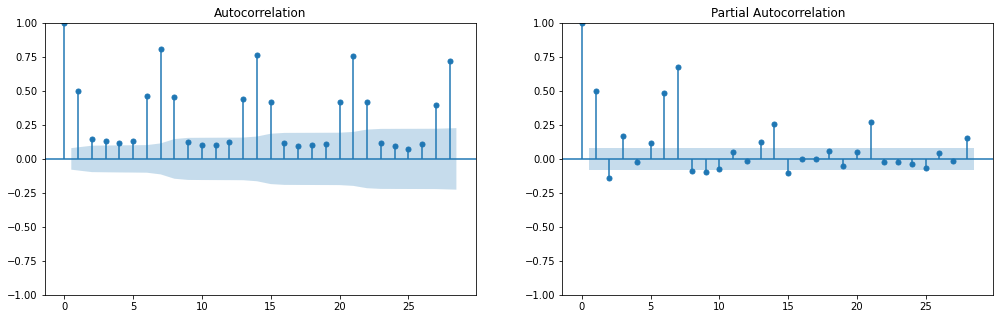

In [40]:
fig, ax = plt.subplots(1,2,figsize=(17,5))
# Decomp es la serie original
plot_acf(decomp, ax=ax[0])
plot_pacf(decomp, ax=ax[1])
plt.show()

La serie no es estacionaria.

##### Pruebo Aplicar transformaciones para llevarla a estacionaria.

* Aplicando transf. de logaritmo

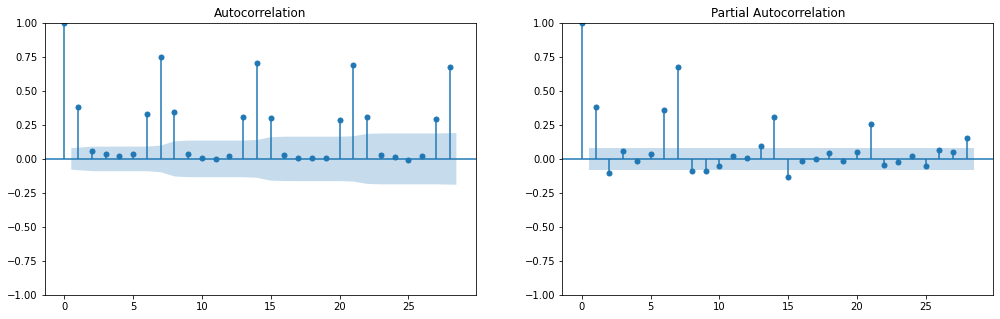

In [41]:
# Decomp2 es aplicando logaritmo
decomp2 = decomp.copy()
decomp2["CANTIDAD"] = np.log(decomp2["CANTIDAD"])
fig, ax = plt.subplots(1,2,figsize=(17,5))
plot_acf(decomp2, ax=ax[0])
plot_pacf(decomp2, ax=ax[1])
plt.show()

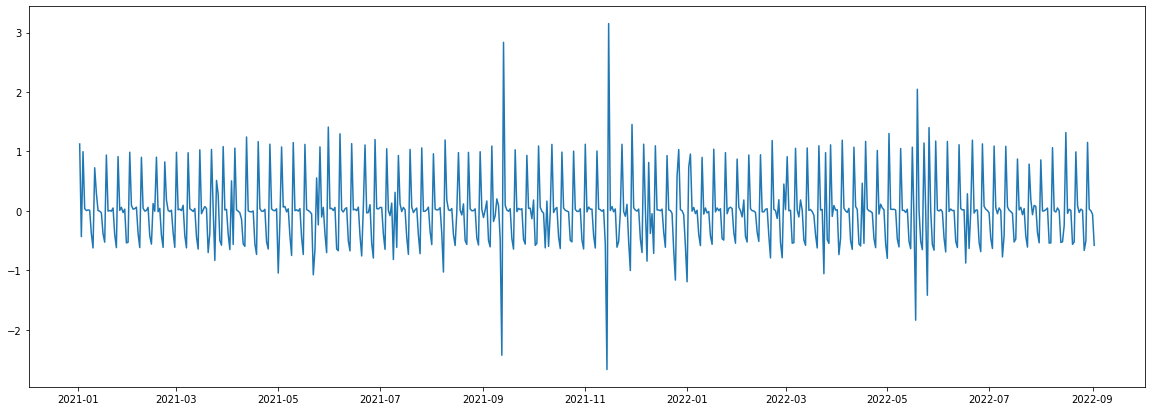

In [42]:
decomp2_diff = decomp2.copy()
decomp2_diff = decomp2_diff.diff()
plt.figure(figsize=(20,7))
plt.plot(decomp2_diff.index, decomp2_diff["CANTIDAD"])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


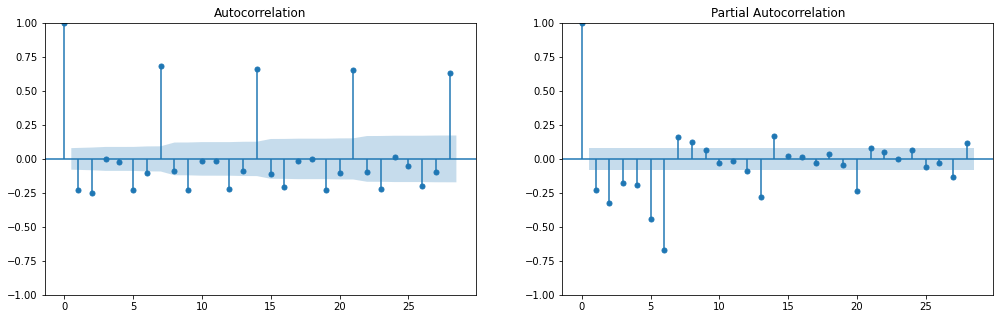

In [43]:
# Decomp2_diff es con logaritmo y diferenciando
fig, ax = plt.subplots(1,2,figsize=(17,5))
plot_acf(decomp2_diff.dropna(), ax=ax[0])
plot_pacf(decomp2_diff.dropna(), ax=ax[1])
plt.show()

* Aplicando Box Cox

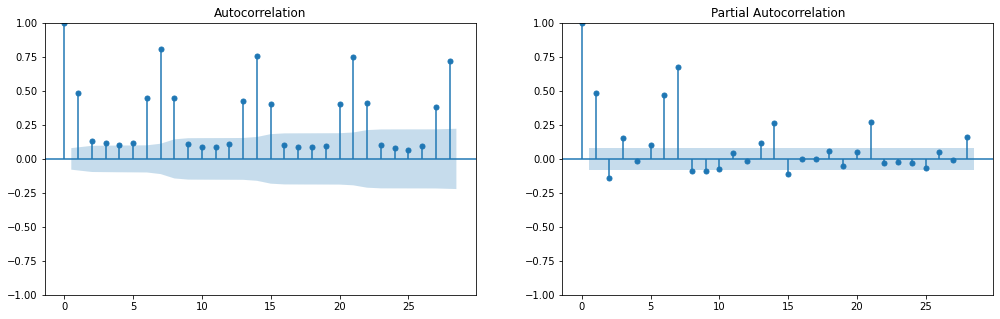

In [44]:
# Decomp3 es aplicando Box Cox
fig, ax = plt.subplots(1,2,figsize=(17,5))
decomp3 = decomp.copy()
decomp3["CANTIDAD"], _ = stats.boxcox(decomp3["CANTIDAD"])
plot_acf(decomp3, ax=ax[0])
plot_pacf(decomp3, ax=ax[1])
plt.show()

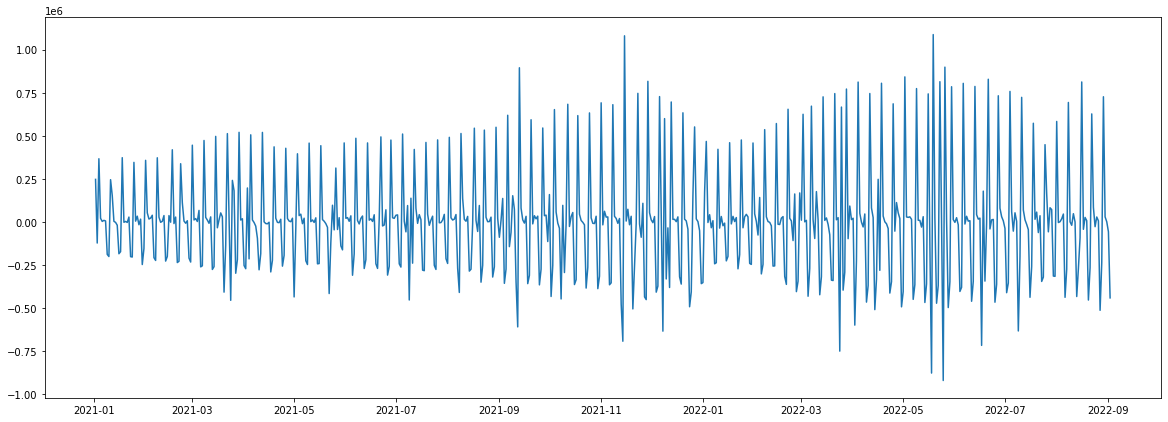

In [45]:
decomp3_diff = decomp3.copy()
decomp3_diff = decomp3_diff.diff()
plt.figure(figsize=(20,7))
plt.plot(decomp3_diff.index, decomp3_diff["CANTIDAD"])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


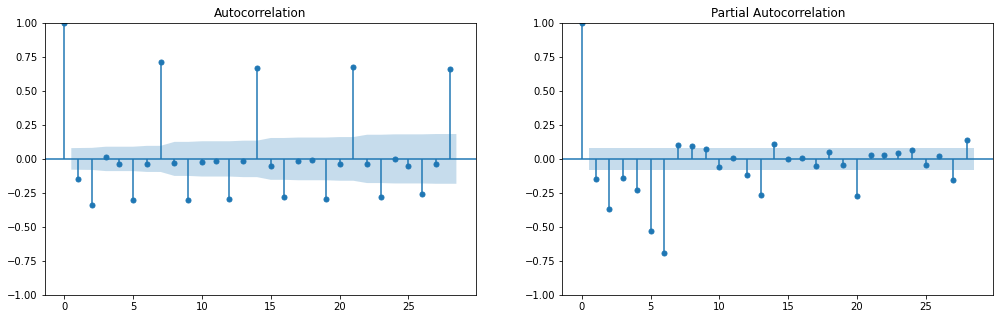

In [46]:
# Decomp3_diff es box cox diferenciada
fig, ax = plt.subplots(1,2,figsize=(17,5))
plot_acf(decomp3_diff.dropna(), ax=ax[0])
plot_pacf(decomp3_diff.dropna(), ax=ax[1])
plt.show()

Si miro el diagrama de autocorrelación sigue sin ser estacionaria, aún luego de haber aplicado Box Cox y diferenciando.

In [47]:
bxcx_adfuller = adfuller(decomp3_diff.dropna())
print(bxcx_adfuller)

(-9.917646479000036, 3.04979964008647e-17, 19, 589, {'1%': -3.4415011513018263, '5%': -2.8664595311890215, '10%': -2.569389981494346}, 15776.942668646381)


In [48]:
bxcx_adfuller[1] < 0.05

True

Segun el test de Dicky Fuller es estacionaria.

In [49]:
bxcx_kpss = kpss(decomp3_diff.dropna())
print(bxcx_kpss)

(0.23366135336230254, 0.1, 149, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [50]:
bxcx_kpss[1] < 0.05

False

Segun el test KPSS es estacionaria.

##### Intento aplicar modelos

Si bien por el gráfico de autocorrelacion la serie no parece ser estacionaria, ambos tests me dieron que sí (uno mira el comportamiento de la varianza y el otro de la media). En este punto asumo que lo que está influyendo en la autocorrelación es la seasonality/estacionalidad. Evalué volver a diferenciar la serie en un orden de 7 (la frecuencia del ciclo - semanal), pero antes voy a intentar modelarla usando SARIMA así como está.

* A la que se le aplicó logaritmo

De los gráficos de autocorrelation y partial autocorrelation estimé que los parámetros del modelo podrían ser:
- p=6
- q=2 o 5
- P=1 o 6
- Q=2 o 5

Pruebo p=6, q=2, P=1 y Q=2

In [51]:
sarimax_decomp2_diff_2 = sm.tsa.statespace.SARIMAX(decomp2_diff, order=(6,0,2), seasonal_order=(1,0,2,7)).fit(disp=-1)
sarimax_decomp2_diff_2.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          CANTIDAD   No. Observations:                  610
Model:             SARIMAX(6, 0, 2)x(1, 0, 2, 7)   Log Likelihood                 -92.808
Date:                           Tue, 11 Oct 2022   AIC                            209.617
Time:                                   22:23:05   BIC                            262.578
Sample:                               01-01-2021   HQIC                           230.219
                                    - 09-02-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6705      0.075     -8.936      0.000      -0.817      -0.523
ar.L2          0.2956      0.052      5.731      0.000       0.195       0.397
ar.L3          0.1657      0.057      2.884      0.004       0.053       0.278
ar.L4          0.1262      0.077      1.639      0.101      -0.025       0.277
ar.L5          0.0598      0.086      0.694      0.488      -0.109       0.229
ar.L6          0.0794      0.071      1.125      0.260      -0.059       0.218
ma.L1         -0.0661      0.066     -0.998      0.318      -0.196       0.064
ma.L2         -0.9251      0.066    -13.933      0.000      -1.055      -0.795
ar.S.L7        0.9994      0.001   1008.960      0.000       0.997       1.001
ma.S.L7       -0.7958      0.041    -19.446      0.000      -0.876      -0.716
ma.S.L14      -0.1600      0.047     -3.437      0.001      -0.251      -0.069
sigma2         0.0766      0.002     36.352      0.000       0.072       0.081
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              6913.29
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -3.00
Prob(H) (two-sided):                  0.32   Kurtosis:                        18.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

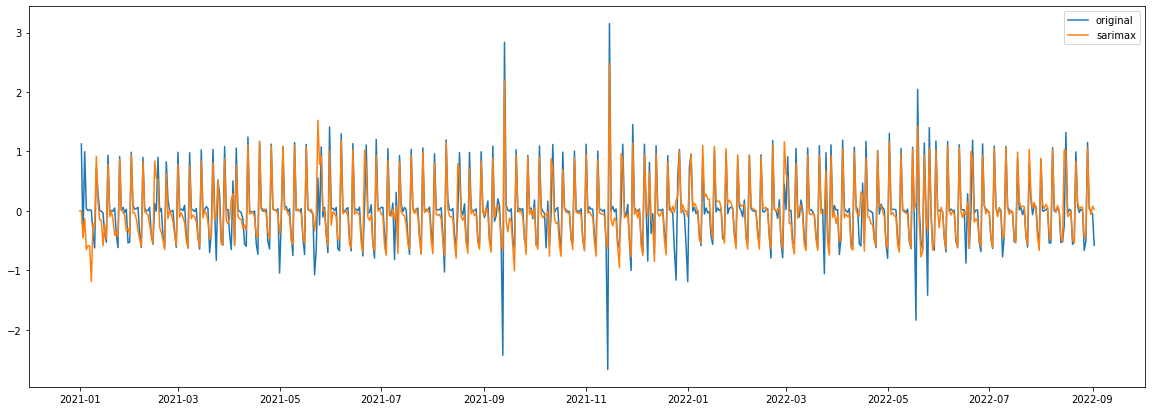

In [52]:
plt.figure(figsize=(20,7))
plt.plot(decomp2_diff.index, decomp2_diff["CANTIDAD"], label='original')
plt.plot(decomp2_diff.index, sarimax_decomp2_diff_2.fittedvalues, label='sarimax')
plt.legend()

Para p=6, q=5, P=1 y Q=2 el resultado fue peor. AIC=248.79 y BIC=314.995

Para p=6, q=5, P=1, Q=5 el resultado fue peor. AIC=239.729 y BIC=319.172

Para p=6, q=5, P=6, Q=5 el resultado fue peor. AIC=217.959 y BIC=319.469

Pruebo p=6, q=2, P=6, Q=2

In [53]:
sarimax_decomp2_diff_2 = sm.tsa.statespace.SARIMAX(decomp2_diff, order=(6,0,2), seasonal_order=(6,0,2,7)).fit(disp=-1)
sarimax_decomp2_diff_2.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          CANTIDAD   No. Observations:                  610
Model:             SARIMAX(6, 0, 2)x(6, 0, 2, 7)   Log Likelihood                 -87.293
Date:                           Tue, 11 Oct 2022   AIC                            208.585
Time:                                   22:23:24   BIC                            283.614
Sample:                               01-01-2021   HQIC                           237.771
                                    - 09-02-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5739      0.252     -2.279      0.023      -1.068      -0.080
ar.L2          0.2002      0.082      2.431      0.015       0.039       0.362
ar.L3          0.0944      0.072      1.311      0.190      -0.047       0.236
ar.L4          0.0416      0.089      0.468      0.640      -0.133       0.216
ar.L5         -0.0150      0.089     -0.169      0.866      -0.190       0.159
ar.L6          0.0537      0.079      0.677      0.499      -0.102       0.209
ma.L1         -0.1668      0.254     -0.658      0.511      -0.664       0.330
ma.L2         -0.7540      0.239     -3.161      0.002      -1.222      -0.286
ar.S.L7        0.1833      0.067      2.751      0.006       0.053       0.314
ar.S.L14       0.9430      0.084     11.213      0.000       0.778       1.108
ar.S.L21      -0.1376      0.081     -1.702      0.089      -0.296       0.021
ar.S.L28       0.0117      0.082      0.143      0.886      -0.149       0.173
ar.S.L35      -0.0387      0.071     -0.544      0.586      -0.178       0.101
ar.S.L42       0.0381      0.060      0.634      0.526      -0.080       0.156
ma.S.L7       -0.0034      0.091     -0.037      0.970      -0.181       0.174
ma.S.L14      -0.9687      0.082    -11.836      0.000      -1.129      -0.808
sigma2         0.0740      0.003     23.169      0.000       0.068       0.080
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              8227.44
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -3.18
Prob(H) (two-sided):                  0.42   Kurtosis:                        19.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

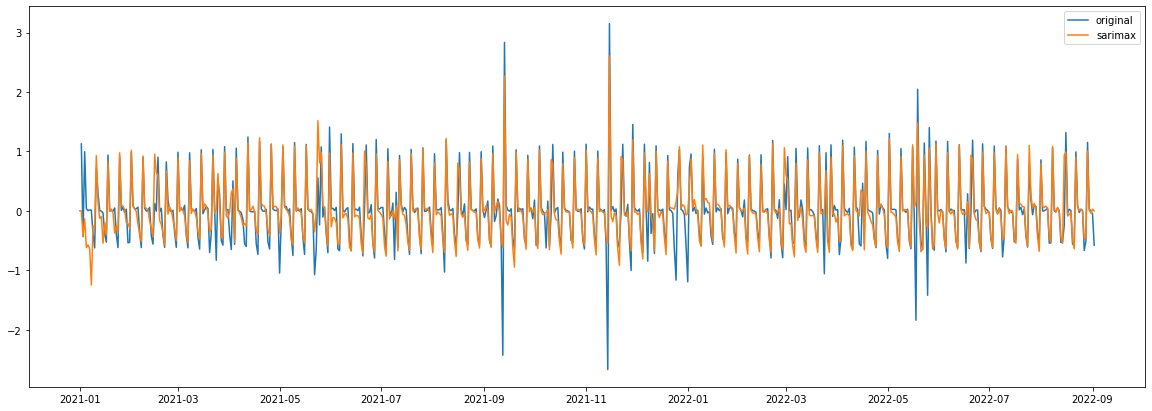

In [54]:
plt.figure(figsize=(20,7))
plt.plot(decomp2_diff.index, decomp2_diff["CANTIDAD"], label='original')
plt.plot(decomp2_diff.index, sarimax_decomp2_diff_2.fittedvalues, label='sarimax')
plt.legend()

* A la que se le aplicó Box Cox

In [55]:
sarimax_decomp3_diff = sm.tsa.statespace.SARIMAX(decomp3_diff).fit(disp=-1)
sarimax_decomp3_diff.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               CANTIDAD   No. Observations:                  610
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -8559.807
Date:                Tue, 11 Oct 2022   AIC                          17123.613
Time:                        22:23:24   BIC                          17132.440
Sample:                    01-01-2021   HQIC                         17127.047
                         - 09-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1517      0.037     -4.109      0.000      -0.224      -0.079
sigma2      9.468e+10   1.44e-13   6.59e+23      0.000    9.47e+10    9.47e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.94   Jarque-Bera (JB):                27.46
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               3.02   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

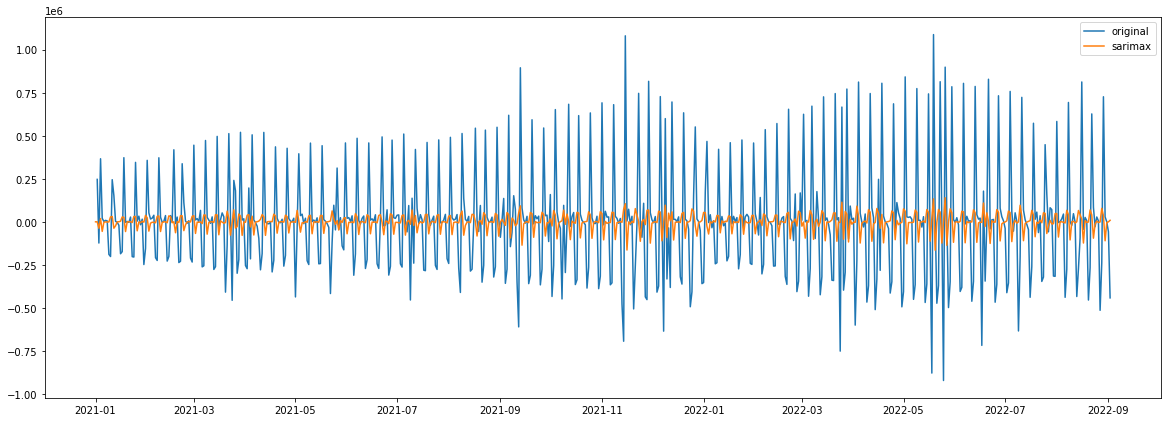

In [56]:
plt.figure(figsize=(20,7))
plt.plot(decomp3_diff.index, decomp3_diff["CANTIDAD"], label='original')
plt.plot(decomp3_diff.index, sarimax_decomp3_diff.fittedvalues, label='sarimax')
plt.legend()

De los gráficos de autocorrelation y partial autocorrelation estimé que los parámetros del modelo podrían ser:
- p=6
- q=2 o 5
- P=1 o 6
- Q=2 o 5

Pruebo p=6, q=2, P=1 y Q=2

In [57]:
sarimax_decomp3_diff_2 = sm.tsa.statespace.SARIMAX(decomp3_diff, order=(6,0,2), seasonal_order=(1,0,2,7)).fit(disp=-1)
sarimax_decomp3_diff_2.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          CANTIDAD   No. Observations:                  610
Model:             SARIMAX(6, 0, 2)x(1, 0, 2, 7)   Log Likelihood               -8122.387
Date:                           Tue, 11 Oct 2022   AIC                          16268.773
Time:                                   22:23:27   BIC                          16321.735
Sample:                               01-01-2021   HQIC                         16289.375
                                    - 09-02-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5931      0.105     -5.626      0.000      -0.800      -0.386
ar.L2          0.2844      0.073      3.907      0.000       0.142       0.427
ar.L3          0.1888      0.065      2.919      0.004       0.062       0.316
ar.L4          0.1381      0.076      1.808      0.071      -0.012       0.288
ar.L5          0.0448      0.086      0.523      0.601      -0.123       0.213
ar.L6          0.1132      0.069      1.644      0.100      -0.022       0.248
ma.L1         -0.1041      0.099     -1.050      0.294      -0.298       0.090
ma.L2         -0.8848      0.098     -9.006      0.000      -1.077      -0.692
ar.S.L7        0.9977      0.003    309.076      0.000       0.991       1.004
ma.S.L7       -0.6936      0.052    -13.393      0.000      -0.795      -0.592
ma.S.L14      -0.2129      0.055     -3.858      0.000      -0.321      -0.105
sigma2      2.819e+10   2.51e-12   1.12e+22      0.000    2.82e+10    2.82e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2647.05
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.90   Skew:                            -2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.38e+37. Standard errors may be unstable.
"""

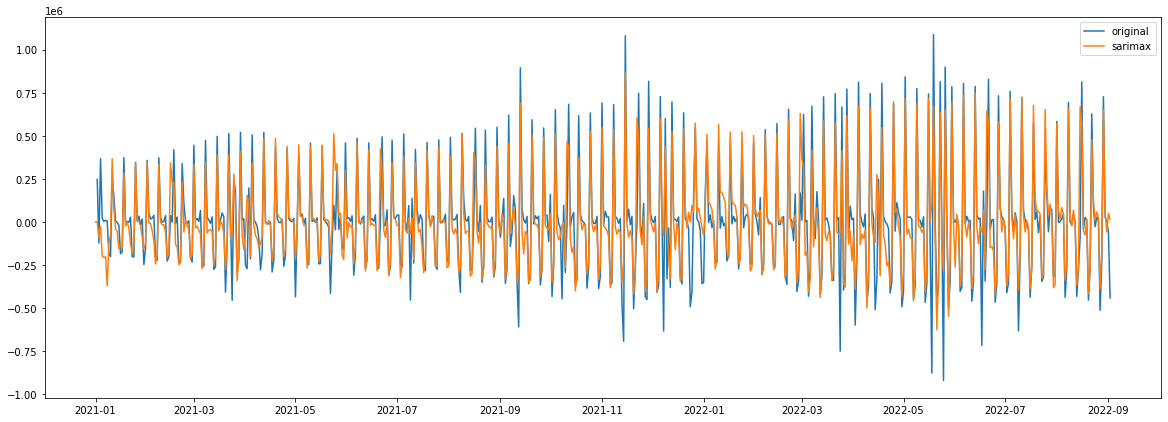

In [58]:
plt.figure(figsize=(20,7))
plt.plot(decomp3_diff.index, decomp3_diff["CANTIDAD"], label='original')
plt.plot(decomp3_diff.index, sarimax_decomp3_diff_2.fittedvalues, label='sarimax')
plt.legend()

Pruebo p=6, q=2, P=6 y Q=2

In [59]:
sarimax_decomp3_diff_2 = sm.tsa.statespace.SARIMAX(decomp3_diff, order=(6,0,2), seasonal_order=(6,0,2,7)).fit(disp=-1)
sarimax_decomp3_diff_2.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          CANTIDAD   No. Observations:                  610
Model:             SARIMAX(6, 0, 2)x(6, 0, 2, 7)   Log Likelihood               -8118.489
Date:                           Tue, 11 Oct 2022   AIC                          16270.977
Time:                                   22:23:52   BIC                          16346.006
Sample:                               01-01-2021   HQIC                         16300.163
                                    - 09-02-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4689      0.380     -1.236      0.217      -1.213       0.275
ar.L2          0.1545      0.119      1.299      0.194      -0.079       0.388
ar.L3          0.1200      0.084      1.436      0.151      -0.044       0.284
ar.L4          0.0360      0.094      0.385      0.701      -0.147       0.219
ar.L5         -0.0475      0.096     -0.496      0.620      -0.235       0.140
ar.L6          0.0653      0.082      0.795      0.426      -0.096       0.226
ma.L1         -0.2506      0.383     -0.654      0.513      -1.002       0.501
ma.L2         -0.6673      0.361     -1.848      0.065      -1.375       0.040
ar.S.L7        0.2677      0.112      2.393      0.017       0.048       0.487
ar.S.L14       0.9411      0.124      7.594      0.000       0.698       1.184
ar.S.L21      -0.1614      0.081     -1.996      0.046      -0.320      -0.003
ar.S.L28       0.0446      0.098      0.455      0.649      -0.148       0.237
ar.S.L35      -0.0935      0.068     -1.381      0.167      -0.226       0.039
ar.S.L42       0.0006      0.073      0.009      0.993      -0.142       0.143
ma.S.L7        0.0220      0.123      0.179      0.858      -0.219       0.263
ma.S.L14      -0.9400      0.089    -10.586      0.000      -1.114      -0.766
sigma2      2.819e+10   4.18e-11   6.75e+20      0.000    2.82e+10    2.82e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2991.40
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.84   Skew:                            -2.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.8e+36. Standard errors may be unstable.
"""

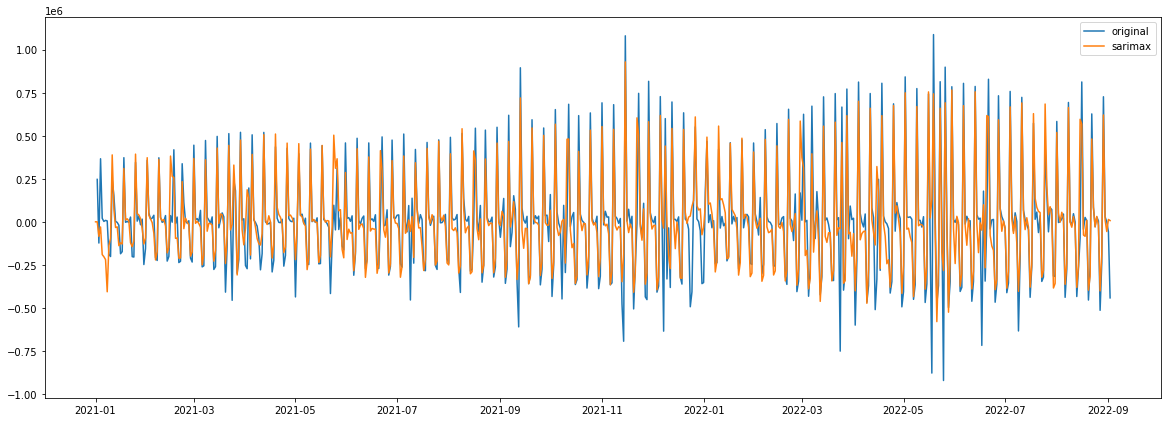

In [60]:
plt.figure(figsize=(20,7))
plt.plot(decomp3_diff.index, decomp3_diff["CANTIDAD"], label='original')
plt.plot(decomp3_diff.index, sarimax_decomp3_diff_2.fittedvalues, label='sarimax')
plt.legend()

##### Ajuste sobre la serie original

* Para la transformación Logarítmica

In [61]:
sarimax_decomp2 = sm.tsa.statespace.SARIMAX(decomp2, order=(6,0,2), seasonal_order=(6,1,2,7)).fit(disp=-1)
sarimax_decomp2.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          CANTIDAD   No. Observations:                  610
Model:             SARIMAX(6, 0, 2)x(6, 1, 2, 7)   Log Likelihood                 -82.797
Date:                           Tue, 11 Oct 2022   AIC                            199.594
Time:                                   22:24:40   BIC                            274.426
Sample:                               01-01-2021   HQIC                           228.718
                                    - 09-02-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2014      0.088      2.300      0.021       0.030       0.373
ar.L2          0.9962      0.094     10.575      0.000       0.812       1.181
ar.L3         -0.1297      0.065     -1.986      0.047      -0.258      -0.002
ar.L4         -0.0317      0.097     -0.328      0.743      -0.221       0.158
ar.L5         -0.0617      0.053     -1.163      0.245      -0.166       0.042
ar.L6          0.0249      0.076      0.329      0.742      -0.123       0.173
ma.L1          0.0527      0.057      0.928      0.354      -0.059       0.164
ma.L2         -0.9228      0.045    -20.371      0.000      -1.012      -0.834
ar.S.L7       -0.8360      0.223     -3.749      0.000      -1.273      -0.399
ar.S.L14       0.0763      0.080      0.957      0.339      -0.080       0.233
ar.S.L21      -0.0194      0.085     -0.228      0.819      -0.186       0.147
ar.S.L28      -0.0090      0.079     -0.114      0.909      -0.164       0.146
ar.S.L35      -0.0458      0.087     -0.529      0.597      -0.216       0.124
ar.S.L42      -0.0201      0.067     -0.301      0.763      -0.151       0.111
ma.S.L7       -0.0552      0.750     -0.074      0.941      -1.525       1.415
ma.S.L14      -0.9432      0.608     -1.551      0.121      -2.135       0.249
sigma2         0.0732      0.043      1.711      0.087      -0.011       0.157
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              8938.48
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -3.22
Prob(H) (two-sided):                  0.29   Kurtosis:                        20.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

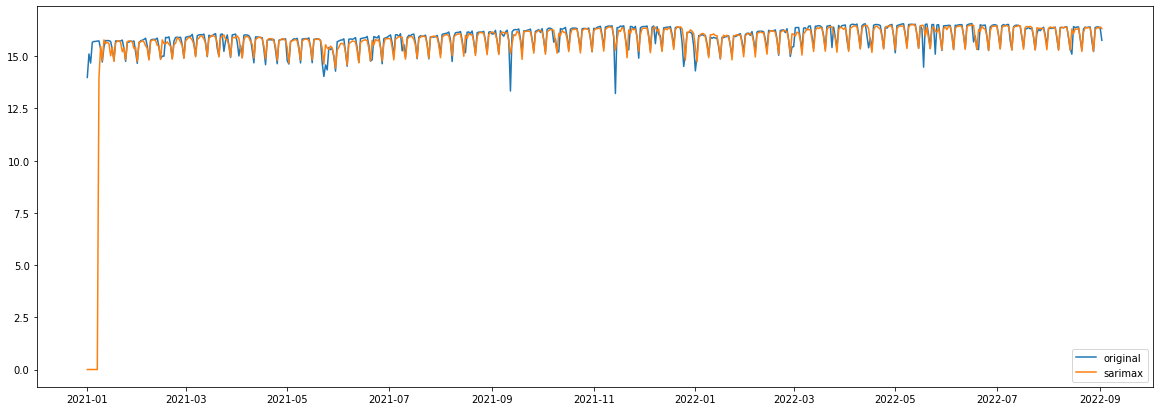

In [62]:
plt.figure(figsize=(20,7))
plt.plot(decomp2.index, decomp2["CANTIDAD"], label='original')
plt.plot(decomp2.index, sarimax_decomp2.fittedvalues, label='sarimax')
plt.legend()

* Para la transformación Box Cox

In [63]:
sarimax_decomp3 = sm.tsa.statespace.SARIMAX(decomp3, order=(6,0,2), seasonal_order=(1,1,2,7)).fit(disp=-1)
sarimax_decomp3.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          CANTIDAD   No. Observations:                  610
Model:             SARIMAX(6, 0, 2)x(1, 1, 2, 7)   Log Likelihood               -8044.440
Date:                           Tue, 11 Oct 2022   AIC                          16112.879
Time:                                   22:24:47   BIC                          16165.702
Sample:                               01-01-2021   HQIC                         16133.438
                                    - 09-02-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2348      0.159      1.479      0.139      -0.076       0.546
ar.L2          0.8659      0.153      5.648      0.000       0.565       1.166
ar.L3         -0.0781      0.070     -1.108      0.268      -0.216       0.060
ar.L4         -0.0188      0.105     -0.179      0.858      -0.225       0.188
ar.L5         -0.1127      0.077     -1.460      0.144      -0.264       0.039
ar.L6          0.0919      0.079      1.161      0.245      -0.063       0.247
ma.L1          0.0598      0.151      0.396      0.692      -0.236       0.356
ma.L2         -0.8263      0.109     -7.600      0.000      -1.039      -0.613
ar.S.L7       -0.1937      0.390     -0.497      0.619      -0.958       0.570
ma.S.L7       -0.5559      0.387     -1.435      0.151      -1.315       0.203
ma.S.L14      -0.3379      0.347     -0.973      0.331      -1.019       0.343
sigma2      3.162e+10   2.67e-11   1.18e+21      0.000    3.16e+10    3.16e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              3525.41
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                            -2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.23e+36. Standard errors may be unstable.
"""

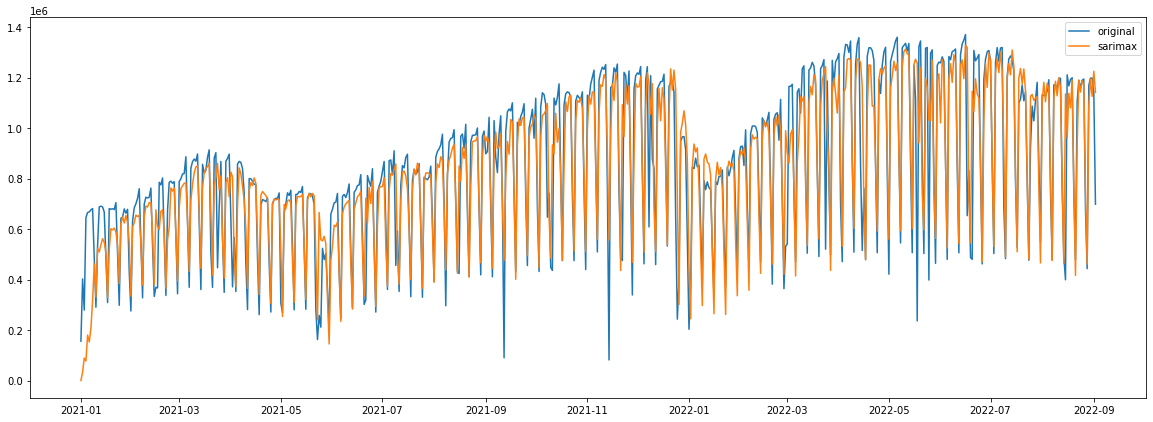

In [64]:
plt.figure(figsize=(20,7))
plt.plot(decomp3.index, decomp3["CANTIDAD"], label='original')
plt.plot(decomp3.index, sarimax_decomp3.fittedvalues, label='sarimax')
plt.legend()

##### Análisis de Residuos

El test de Ljung-Box dio menor a 0.05 por lo que no tengo evidencia suficiente para afirmar que los residuos están descorrelacionados.

In [65]:
residuals = pd.DataFrame(sarimax_decomp2.resid)

In [66]:
residuals.head(10)

0
DIA_TRANSPORTE           
2021-01-01      13.979548
2021-01-02      15.103871
2021-01-03      14.669730
2021-01-04      15.664368
2021-01-05      15.701266
2021-01-06      15.705370
2021-01-07      15.720176
2021-01-08       1.749513
2021-01-09      -0.121012
2021-01-10      -0.069338

In [67]:
residuals.iloc[7:]

0
DIA_TRANSPORTE          
2021-01-08      1.749513
2021-01-09     -0.121012
2021-01-10     -0.069338
2021-01-11     -0.335103
2021-01-12      0.133816
...                  ...
2022-08-29      0.114598
2022-08-30      0.033644
2022-08-31      0.053716
2022-09-01     -0.055720
2022-09-02     -0.564015

[603 rows x 1 columns]

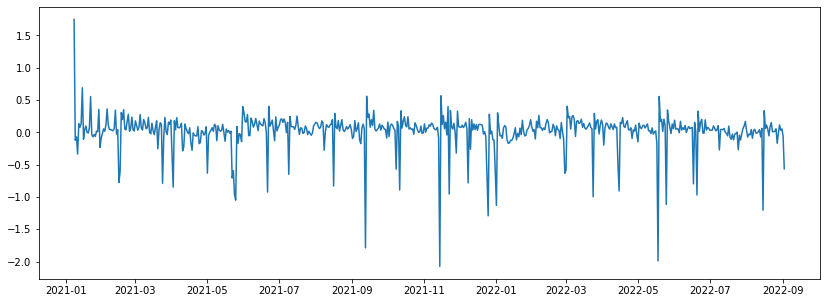

In [68]:
plt.figure(figsize=(14,5))
plt.plot(residuals.iloc[7:].index, residuals[0].iloc[7:])
plt.show()

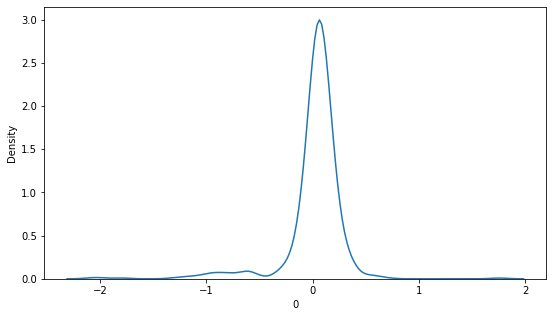

In [69]:
plt.figure(figsize=(9,5))
sns.kdeplot(data=residuals[7:], x=residuals[0].iloc[7:])
plt.show()

In [70]:
residuals[7:].describe()

0
count  603.000000
mean     0.017315
std      0.279788
min     -2.075749
25%     -0.013410
50%      0.057509
75%      0.124319
max      1.749513

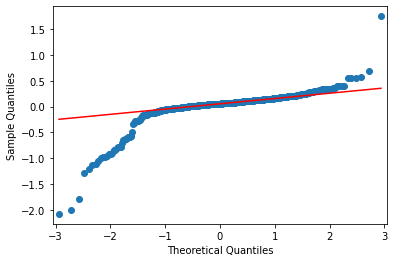

In [71]:
sm.qqplot(residuals[0].iloc[7:], line='q')
plt.show()

##### Análisis Espectral

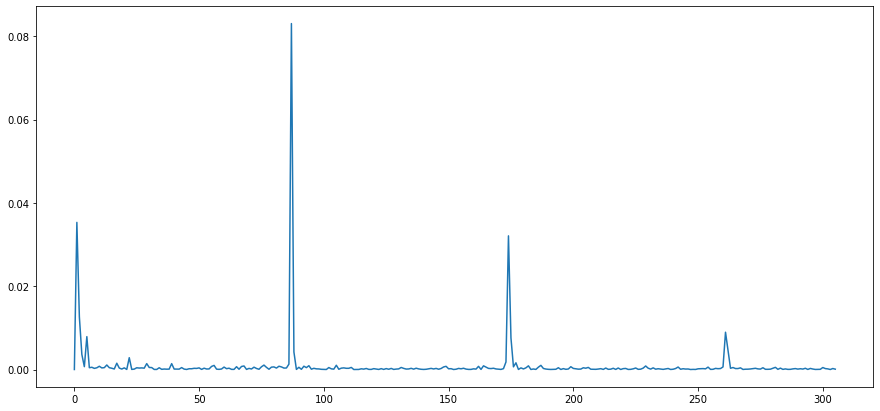

In [72]:
plt.figure(figsize=(15,7))
G, Pyy_den = signal.periodogram(decomp2.CANTIDAD.dropna(), len(decomp2.CANTIDAD.dropna()))
plt.plot(G, Pyy_den)
plt.show()

Del periodograma se puede ver que la frecuencia principal está en la 87. 

Al ser N=610 muestras, el Seasonality nos da 610/87 = 7 (aprox.) 

##### Análisis de Intervenciones

Se ve una intervención del 23 al 30 de mayo de 2021. (posiciones 142 a 149 en la serie).

https://www.argentina.gob.ar/noticias/el-peor-momento-de-la-pandemia-nuevas-medidas-para-reducir-los-contagios



In [73]:
#%matplotlib qt
#plt.plot(decomp2.index, decomp2["CANTIDAD"])

In [74]:
exog = decomp2.copy()
exog

CANTIDAD
DIA_TRANSPORTE           
2021-01-01      13.979548
2021-01-02      15.103871
2021-01-03      14.669730
2021-01-04      15.664368
2021-01-05      15.701267
...                   ...
2022-08-29      16.369823
2022-08-30      16.398720
2022-08-31      16.398726
2022-09-01      16.339948
2022-09-02      15.758832

[610 rows x 1 columns]

In [75]:
exog["EXOG"] = np.zeros(len(decomp2))
exog

CANTIDAD  EXOG
DIA_TRANSPORTE                 
2021-01-01      13.979548   0.0
2021-01-02      15.103871   0.0
2021-01-03      14.669730   0.0
2021-01-04      15.664368   0.0
2021-01-05      15.701267   0.0
...                   ...   ...
2022-08-29      16.369823   0.0
2022-08-30      16.398720   0.0
2022-08-31      16.398726   0.0
2022-09-01      16.339948   0.0
2022-09-02      15.758832   0.0

[610 rows x 2 columns]

In [76]:
exog.iloc[142:145, exog.columns.get_loc('EXOG')] = 1
exog.iloc[140:150]

CANTIDAD  EXOG
DIA_TRANSPORTE                 
2021-05-21      15.758058   0.0
2021-05-22      14.681296   0.0
2021-05-23      14.024515   1.0
2021-05-24      14.577963   1.0
2021-05-25      14.340962   1.0
2021-05-26      15.416950   0.0
2021-05-27      15.311396   0.0
2021-05-28      15.369611   0.0
2021-05-29      14.984336   0.0
2021-05-30      14.279802   0.0

In [77]:
sarimax_exog = sm.tsa.statespace.SARIMAX(exog["CANTIDAD"], exog=exog["EXOG"], order=(6,0,2), seasonal_order=(6,1,2,7)).fit(disp=-1)
sarimax_exog.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          CANTIDAD   No. Observations:                  610
Model:             SARIMAX(6, 0, 2)x(6, 1, 2, 7)   Log Likelihood                 -67.239
Date:                           Tue, 11 Oct 2022   AIC                            170.478
Time:                                   22:25:30   BIC                            249.712
Sample:                               01-01-2021   HQIC                           201.315
                                    - 09-02-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EXOG          -1.0233      0.139     -7.341      0.000      -1.297      -0.750
ar.L1          0.1462      0.104      1.411      0.158      -0.057       0.349
ar.L2          0.9139      0.109      8.417      0.000       0.701       1.127
ar.L3         -0.0780      0.060     -1.303      0.193      -0.195       0.039
ar.L4         -0.0015      0.103     -0.015      0.988      -0.204       0.201
ar.L5         -0.0434      0.066     -0.660      0.509      -0.172       0.085
ar.L6          0.0574      0.071      0.806      0.420      -0.082       0.197
ma.L1          0.0541      0.088      0.617      0.537      -0.118       0.226
ma.L2         -0.8683      0.060    -14.574      0.000      -0.985      -0.752
ar.S.L7       -0.7785      1.117     -0.697      0.486      -2.968       1.411
ar.S.L14       0.0578      0.147      0.394      0.694      -0.230       0.345
ar.S.L21      -0.0230      0.094     -0.246      0.806      -0.207       0.161
ar.S.L28      -0.0219      0.089     -0.245      0.806      -0.197       0.153
ar.S.L35      -0.0635      0.106     -0.598      0.550      -0.272       0.145
ar.S.L42      -0.0328      0.066     -0.498      0.618      -0.162       0.096
ma.S.L7       -0.1046      1.126     -0.093      0.926      -2.311       2.102
ma.S.L14      -0.8903      1.115     -0.798      0.425      -3.076       1.296
sigma2         0.0700      0.011      6.657      0.000       0.049       0.091
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             11114.23
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                            -3.41
Prob(H) (two-sided):                  0.02   Kurtosis:                        22.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

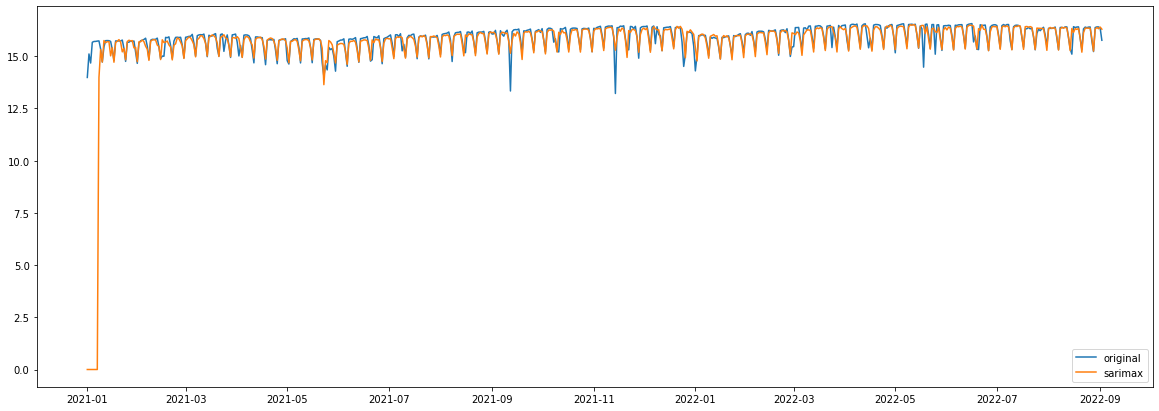

In [78]:
plt.figure(figsize=(20,7))
plt.plot(decomp2.index, decomp2["CANTIDAD"], label='original')
plt.plot(decomp2.index, sarimax_exog.fittedvalues, label='sarimax')
plt.legend()

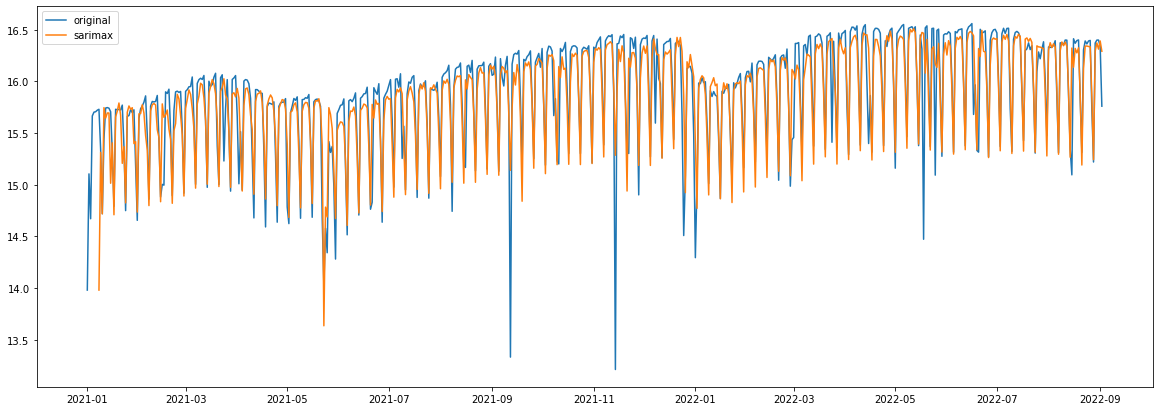

In [84]:
plt.figure(figsize=(20,7))
plt.plot(decomp2.index, decomp2["CANTIDAD"], label='original')
plt.plot(decomp2[7:].index, sarimax_exog.fittedvalues[7:], label='sarimax')
plt.legend()

##### Veo los residuos de nuevo para la serie con intervenciones

In [85]:
residuals_exog = pd.DataFrame(sarimax_exog.resid)
residuals_exog.head(10)

0
DIA_TRANSPORTE           
2021-01-01      13.979548
2021-01-02      15.103871
2021-01-03      14.669730
2021-01-04      15.664368
2021-01-05      15.701267
2021-01-06      15.705370
2021-01-07      15.720177
2021-01-08       1.749514
2021-01-09       0.030863
2021-01-10       0.000837

In [86]:
residuals_exog.iloc[7:]

0
DIA_TRANSPORTE          
2021-01-08      1.749514
2021-01-09      0.030863
2021-01-10      0.000837
2021-01-11     -0.301945
2021-01-12      0.096919
...                  ...
2022-08-29      0.078841
2022-08-30      0.027799
2022-08-31      0.087401
2022-09-01     -0.050171
2022-09-02     -0.531586

[603 rows x 1 columns]

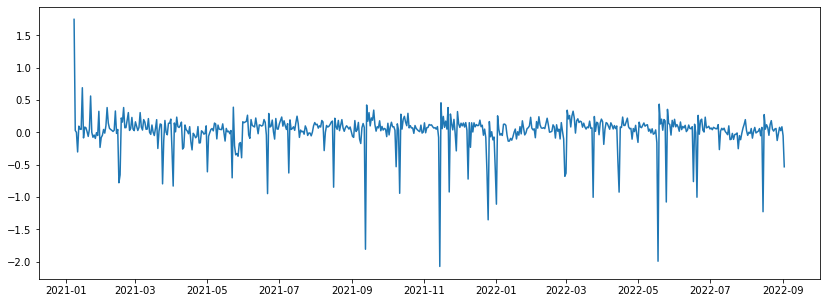

In [89]:
plt.figure(figsize=(14,5))
plt.plot(residuals_exog.iloc[7:].index, residuals_exog[0].iloc[7:])
plt.show()

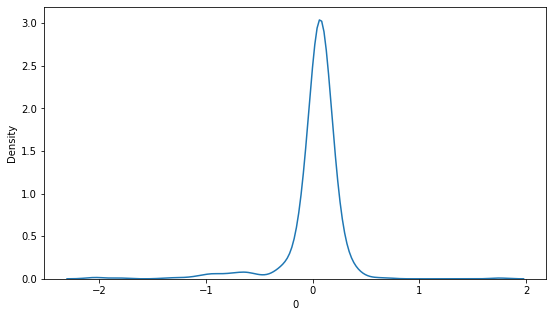

In [90]:
plt.figure(figsize=(9,5))
sns.kdeplot(data=residuals_exog[7:], x=residuals_exog[0].iloc[7:])
plt.show()

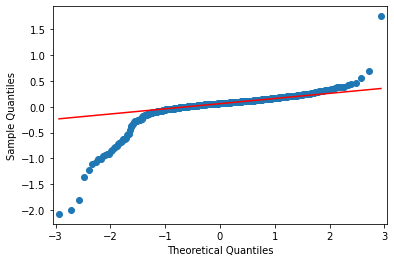

In [91]:
sm.qqplot(residuals_exog[0].iloc[7:], line='q')
plt.show()

##### Análisis de Outliers

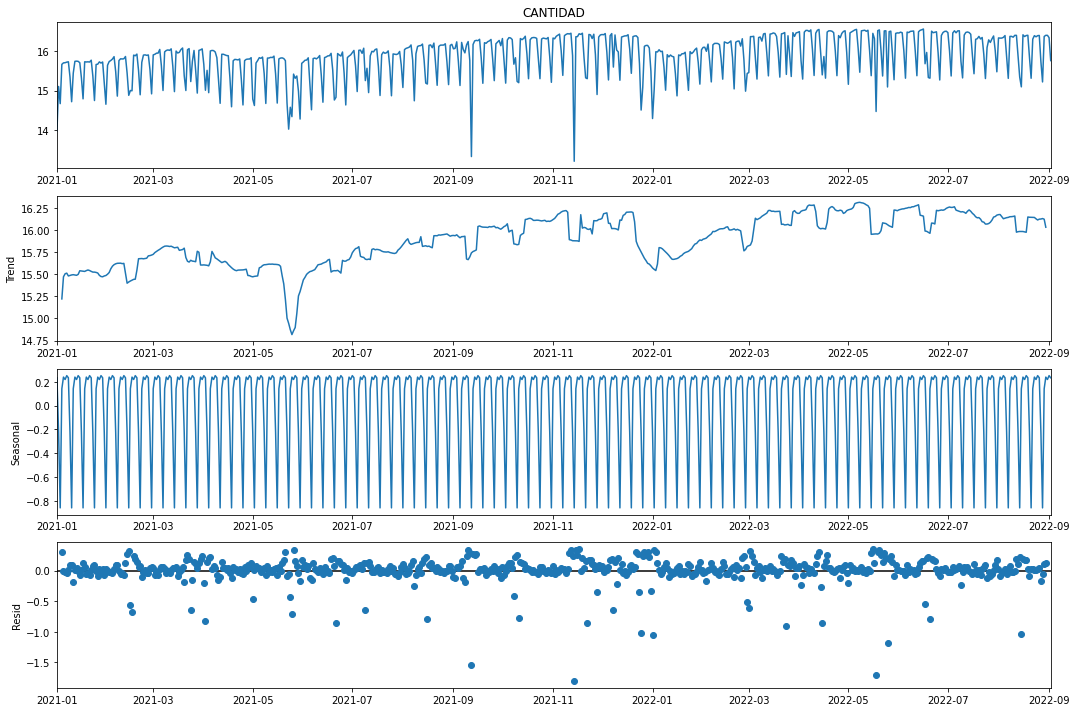

In [79]:
additive = sm.tsa.seasonal_decompose(decomp2.CANTIDAD, model='additive')
fig = additive.plot()
fig.set_size_inches(15,10)
fig.tight_layout()
plt.show()

(array([  2.,   1.,   1.,   3.,   8.,   9.,   6.,  43., 436.,  95.]),
 array([-1.80757432, -1.59143956, -1.37530481, -1.15917005, -0.94303529,
        -0.72690054, -0.51076578, -0.29463102, -0.07849627,  0.13763849,
         0.35377325]),
 <BarContainer object of 10 artists>)

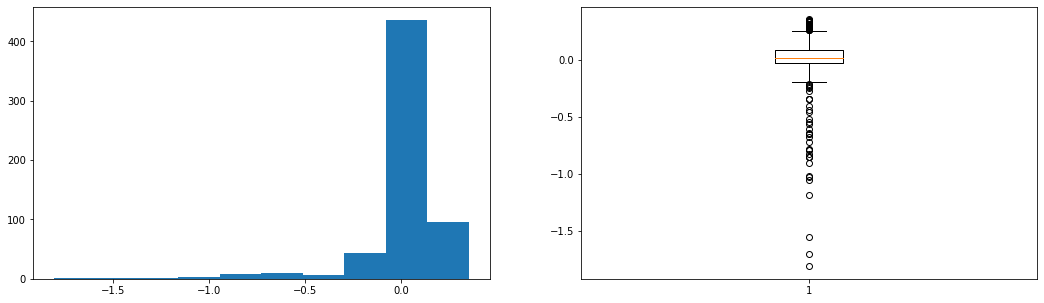

In [80]:
decomp2_resid = additive.resid
fig, ax = plt.subplots(1,2,figsize = (18,5),)
ax[1].boxplot(decomp2_resid.dropna()) 
ax[0].hist(decomp2_resid.dropna())

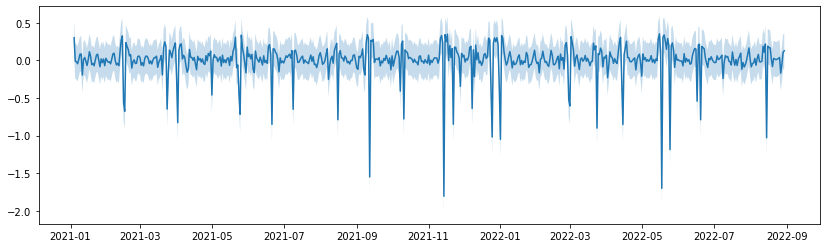

In [81]:
fig = plt.figure(figsize=(14,4))
MAD = decomp2_resid.mad()
plt.plot(decomp2_resid)
plt.fill_between(x=decomp2_resid.index, y1=decomp2_resid - 2*MAD, y2=decomp2_resid + 2*MAD, alpha=0.25)

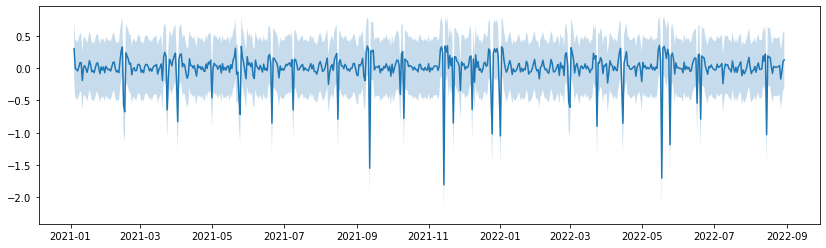

In [82]:
fig = plt.figure(figsize=(14,4))
sd = decomp2_resid.std()
plt.plot(decomp2_resid)
plt.fill_between(x=decomp2_resid.index, y1=decomp2_resid - 2*sd, y2=decomp2_resid + 2*sd, alpha=0.25)

##### Forecast con Sarima

In [341]:
exog

CANTIDAD  EXOG
DIA_TRANSPORTE                 
2021-01-01      13.979548   0.0
2021-01-02      15.103871   0.0
2021-01-03      14.669730   0.0
2021-01-04      15.664368   0.0
2021-01-05      15.701267   0.0
...                   ...   ...
2022-08-29      16.369823   0.0
2022-08-30      16.398720   0.0
2022-08-31      16.398726   0.0
2022-09-01      16.339948   0.0
2022-09-02      15.758832   0.0

[610 rows x 2 columns]

In [343]:
sarimax_train = exog.iloc[:508].copy()
sarimax_test = exog.iloc[508:].copy()

In [344]:
sarimax_exog = sm.tsa.statespace.SARIMAX(sarimax_train["CANTIDAD"], exog=sarimax_train["EXOG"], order=(6,0,2), seasonal_order=(6,1,2,7)).fit(disp=-1)

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



In [350]:
forecast = sarimax_exog.predict(start = sarimax_train.shape[0], end = sarimax_train.shape[0] + sarimax_test.shape[0] -1, exog=sarimax_test["EXOG"])
forecast

2022-05-24    16.322564
2022-05-25    16.258246
2022-05-26    16.300620
2022-05-27    16.357327
2022-05-28    15.855587
                ...    
2022-08-29    16.222364
2022-08-30    16.291166
2022-08-31    16.276005
2022-09-01    16.286158
2022-09-02    16.263391
Freq: D, Name: predicted_mean, Length: 102, dtype: float64

In [354]:
sarimax_prediction = sarimax_test.copy()
sarimax_prediction["PREDICTION"] = forecast
sarimax_prediction.drop(columns=["EXOG"], inplace=True)
sarimax_prediction

CANTIDAD  PREDICTION
DIA_TRANSPORTE                       
2022-05-24      16.513209   16.322564
2022-05-25      15.091773   16.258246
2022-05-26      16.492038   16.300620
2022-05-27      16.504572   16.357327
2022-05-28      15.937353   15.855587
...                   ...         ...
2022-08-29      16.369823   16.222364
2022-08-30      16.398720   16.291166
2022-08-31      16.398726   16.276005
2022-09-01      16.339948   16.286158
2022-09-02      15.758832   16.263391

[102 rows x 2 columns]

Text(0.5, 1.0, 'Prediccion con el dataset de Test')

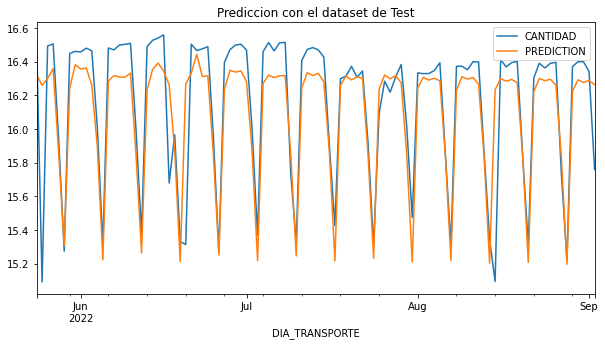

In [355]:
sarimax_prediction.plot(figsize=[10,5])
plt.title("Prediccion con el dataset de Test")

In [356]:
def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.CANTIDAD, df.PREDICTION),
            'rmse' : mean_squared_error(df.CANTIDAD, df.PREDICTION) ** 0.5,
            'r2' : r2_score(df.CANTIDAD, df.PREDICTION)}

In [357]:
sarimax_metrics = calculate_metrics(sarimax_prediction)
sarimax_metrics

{'mae': 0.15366761728055744,
 'rmse': 0.23913080229097872,
 'r2': 0.6946565849515955}

Hago la inversa del logartimo para llevar a magnitudes originales

In [358]:
sarimax_prediction_exp = sarimax_prediction.copy()
sarimax_prediction_exp["CANTIDAD"] = np.exp(sarimax_prediction_exp["CANTIDAD"])
sarimax_prediction_exp["PREDICTION"] = np.exp(sarimax_prediction_exp["PREDICTION"])
sarimax_prediction_exp

CANTIDAD    PREDICTION
DIA_TRANSPORTE                          
2022-05-24      14845527.0  1.226873e+07
2022-05-25       3583223.0  1.150447e+07
2022-05-26      14534531.0  1.200243e+07
2022-05-27      14717850.0  1.270273e+07
2022-05-28       8346501.0  7.691200e+06
...                    ...           ...
2022-08-29      12862451.0  1.109898e+07
2022-08-30      13239561.0  1.188950e+07
2022-08-31      13239636.0  1.171060e+07
2022-09-01      12483866.0  1.183010e+07
2022-09-02       6981899.0  1.156382e+07

[102 rows x 2 columns]

Text(0.5, 1.0, 'Prediccion con el dataset de Test')

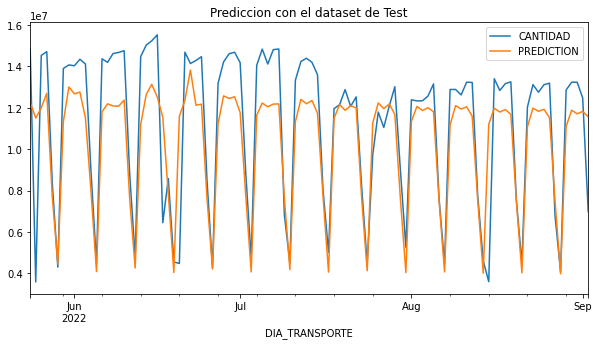

In [359]:
sarimax_prediction_exp.plot(figsize=[10,5])
plt.title("Prediccion con el dataset de Test")

In [360]:
sarimax_metrics_2 = calculate_metrics(sarimax_prediction_exp)
sarimax_metrics_2

{'mae': 1567757.092504255, 'rmse': 2111796.365648482, 'r2': 0.6789632374929819}

##### LSTM

In [21]:
def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [22]:
serie

DIA_TRANSPORTE  CANTIDAD  Year  Month
0       2021-01-01   1178259  2021      1
1       2021-01-02   3626837  2021      1
2       2021-01-03   2349540  2021      1
3       2021-01-04   6352559  2021      1
4       2021-01-05   6591339  2021      1
..             ...       ...   ...    ...
605     2022-08-29  12862451  2022      8
606     2022-08-30  13239561  2022      8
607     2022-08-31  13239636  2022      8
608     2022-09-01  12483866  2022      9
609     2022-09-02   6981899  2022      9

[610 rows x 4 columns]

In [23]:
serie_lstm = serie[["DIA_TRANSPORTE", "CANTIDAD"]]
serie_lstm

DIA_TRANSPORTE  CANTIDAD
0       2021-01-01   1178259
1       2021-01-02   3626837
2       2021-01-03   2349540
3       2021-01-04   6352559
4       2021-01-05   6591339
..             ...       ...
605     2022-08-29  12862451
606     2022-08-30  13239561
607     2022-08-31  13239636
608     2022-09-01  12483866
609     2022-09-02   6981899

[610 rows x 2 columns]

In [24]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["CANTIDAD"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

In [25]:
input_dim = 100

df_generated = generate_time_lags(serie_lstm, input_dim)
df_generated

/var/folders/v5/666psn050jv697dd4014yc000000gn/T/ipykernel_29180/3949347866.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_n[f"lag{n}"] = df_n["CANTIDAD"].shift(n)
/var/folders/v5/666psn050jv697dd4014yc000000gn/T/ipykernel_29180/3949347866.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_n[f"lag{n}"] = df_n["CANTIDAD"].shift(n)


DIA_TRANSPORTE  CANTIDAD        lag1        lag2        lag3        lag4  \
100     2021-04-11   2368613   4310352.0   7522625.0   8679162.0   8987153.0   
101     2021-04-12   8199355   2368613.0   4310352.0   7522625.0   8679162.0   
102     2021-04-13   8195920   8199355.0   2368613.0   4310352.0   7522625.0   
103     2021-04-14   8073605   8195920.0   8199355.0   2368613.0   4310352.0   
104     2021-04-15   7934399   8073605.0   8195920.0   8199355.0   2368613.0   
..             ...       ...         ...         ...         ...         ...   
605     2022-08-29  12862451   4068994.0   6769118.0  13192809.0  13121347.0   
606     2022-08-30  13239561  12862451.0   4068994.0   6769118.0  13192809.0   
607     2022-08-31  13239636  13239561.0  12862451.0   4068994.0   6769118.0   
608     2022-09-01  12483866  13239636.0  13239561.0  12862451.0   4068994.0   
609     2022-09-02   6981899  12483866.0  13239636.0  13239561.0  12862451.0   

           lag5        lag6        lag7        lag8  ...       lag91  \
100   9035733.0   8903766.0   3100663.0   5456749.0  ...   2466528.0   
101   8987153.0   9035733.0   8903766.0   3100663.0  ...   5090755.0   
102   8679162.0   8987153.0   9035733.0   8903766.0  ...   6856011.0   
103   7522625.0   8679162.0   8987153.0   9035733.0  ...   6889261.0   
104   4310352.0   7522625.0   8679162.0   8987153.0  ...   6849803.0   
..          ...         ...         ...         ...  ...         ...   
605  12755757.0  13125474.0  12036539.0   4464674.0  ...  13903242.0   
606  13121347.0  12755757.0  13125474.0  12036539.0  ...  14076630.0   
607  13192809.0  13121347.0  12755757.0  13125474.0  ...  14034616.0   
608   6769118.0  13192809.0  13121347.0  12755757.0  ...  14350736.0   
609   4068994.0   6769118.0  13192809.0  13121347.0  ...  14118964.0   

          lag92       lag93       lag94       lag95       lag96       lag97  \
100   4607956.0   6777112.0   6717167.0   6618440.0   6591339.0   6352559.0   
101   2466528.0   4607956.0   6777112.0   6717167.0   6618440.0   6591339.0   
102   5090755.0   2466528.0   4607956.0   6777112.0   6717167.0   6618440.0   
103   6856011.0   5090755.0   2466528.0   4607956.0   6777112.0   6717167.0   
104   6889261.0   6856011.0   5090755.0   2466528.0   4607956.0   6777112.0   
..          ...         ...         ...         ...         ...         ...   
605   4299723.0   8346501.0  14717850.0  14534531.0   3583223.0  14845527.0   
606  13903242.0   4299723.0   8346501.0  14717850.0  14534531.0   3583223.0   
607  14076630.0  13903242.0   4299723.0   8346501.0  14717850.0  14534531.0   
608  14034616.0  14076630.0  13903242.0   4299723.0   8346501.0  14717850.0   
609  14350736.0  14034616.0  14076630.0  13903242.0   4299723.0   8346501.0   

          lag98       lag99      lag100  
100   2349540.0   3626837.0   1178259.0  
101   6352559.0   2349540.0   3626837.0  
102   6591339.0   6352559.0   2349540.0  
103   6618440.0   6591339.0   6352559.0  
104   6717167.0   6618440.0   6591339.0  
..          ...         ...         ...  
605  14803572.0   4727356.0   9089121.0  
606  14845527.0  14803572.0   4727356.0  
607   3583223.0  14845527.0  14803572.0  
608  14534531.0   3583223.0  14845527.0  
609  14717850.0  14534531.0   3583223.0  

[510 rows x 102 columns]

In [26]:
df_generated.drop(columns=["DIA_TRANSPORTE"], inplace=True)

df_generated.head(1)

CANTIDAD       lag1       lag2       lag3       lag4       lag5  \
100   2368613  4310352.0  7522625.0  8679162.0  8987153.0  9035733.0   

          lag6       lag7       lag8       lag9  ...      lag91      lag92  \
100  8903766.0  3100663.0  5456749.0  3296038.0  ...  2466528.0  4607956.0   

         lag93      lag94      lag95      lag96      lag97      lag98  \
100  6777112.0  6717167.0  6618440.0  6591339.0  6352559.0  2349540.0   

         lag99     lag100  
100  3626837.0  1178259.0  

[1 rows x 101 columns]

In [27]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_generated, 'CANTIDAD', 0.1)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((408, 100), (51, 100), (51, 100), (408, 1), (51, 1), (51, 1))

In [109]:
scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

y_train_sc = scaler.fit_transform(y_train)
y_val_sc = scaler.transform(y_val)
y_test_sc = scaler.transform(y_test)

In [110]:
batch_size = 32

train_features = torch.Tensor(X_train_sc)
train_targets = torch.Tensor(y_train_sc)
val_features = torch.Tensor(X_val_sc)
val_targets = torch.Tensor(y_val_sc)
test_features = torch.Tensor(X_test_sc)
test_targets = torch.Tensor(y_test_sc)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [136]:
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
dropout = 0.1
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

In [28]:
device = 'cpu'

In [91]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = torch.nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [92]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()


    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        #torch.save(self.model.state_dict(), model_path)


    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values


    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [29]:
def get_model(model, model_params):
    models = {
        "lstm": LSTMModel,
    }
    return models.get(model.lower())(**model_params)

[1/100] Training loss: 0.4304	 Validation loss: 0.5876
[2/100] Training loss: 0.1781	 Validation loss: 0.1006
[3/100] Training loss: 0.0628	 Validation loss: 0.0796
[4/100] Training loss: 0.0600	 Validation loss: 0.1141
[5/100] Training loss: 0.0481	 Validation loss: 0.0808
[6/100] Training loss: 0.0488	 Validation loss: 0.0825
[7/100] Training loss: 0.0457	 Validation loss: 0.0759
[8/100] Training loss: 0.0391	 Validation loss: 0.0633
[9/100] Training loss: 0.0326	 Validation loss: 0.0485
[10/100] Training loss: 0.0243	 Validation loss: 0.0398
[50/100] Training loss: 0.0128	 Validation loss: 0.0419
[100/100] Training loss: 0.0106	 Validation loss: 0.0440


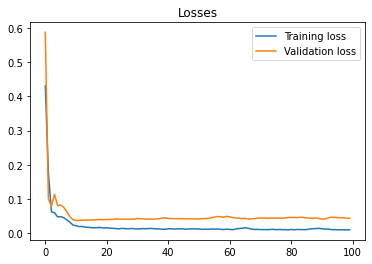

In [137]:
model = get_model('lstm', model_params)

loss_fn = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

In [113]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

In [138]:
df_result = format_predictions(predictions, values, X_test, scaler)

Text(0.5, 1.0, 'Prediccion con el dataset de Test')

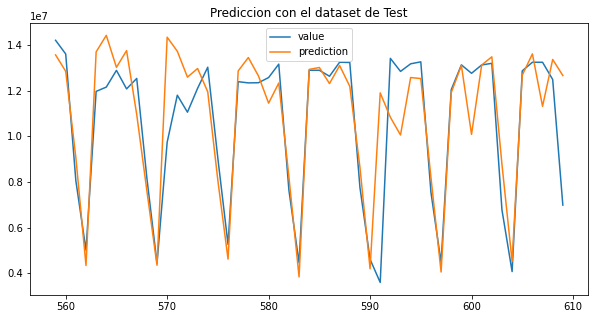

In [139]:
df_result.plot(figsize=[10,5])
plt.title("Prediccion con el dataset de Test")

In [144]:
def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction)}

result_metrics = calculate_metrics(df_result)

In [145]:
result_metrics

{'mae': 1203712.0, 'rmse': 1911308.2067651988, 'r2': 0.655747538572605}

Pruebo usando solo los ultimos 14 lags

In [149]:
df_generated_14 = generate_time_lags(serie_lstm, 14)
df_generated_14.drop(columns=["DIA_TRANSPORTE"], inplace=True)
df_generated_14

CANTIDAD        lag1        lag2        lag3        lag4        lag5  \
14    6616257   6849803.0   6889261.0   6856011.0   5090755.0   2466528.0   
15    4497750   6616257.0   6849803.0   6889261.0   6856011.0   5090755.0   
16    2652005   4497750.0   6616257.0   6849803.0   6889261.0   6856011.0   
17    6777421   2652005.0   4497750.0   6616257.0   6849803.0   6889261.0   
18    6744079   6777421.0   2652005.0   4497750.0   6616257.0   6849803.0   
..        ...         ...         ...         ...         ...         ...   
605  12862451   4068994.0   6769118.0  13192809.0  13121347.0  12755757.0   
606  13239561  12862451.0   4068994.0   6769118.0  13192809.0  13121347.0   
607  13239636  13239561.0  12862451.0   4068994.0   6769118.0  13192809.0   
608  12483866  13239636.0  13239561.0  12862451.0   4068994.0   6769118.0   
609   6981899  12483866.0  13239636.0  13239561.0  12862451.0   4068994.0   

           lag6        lag7        lag8        lag9       lag10       lag11  \
14    4607956.0   6777112.0   6717167.0   6618440.0   6591339.0   6352559.0   
15    2466528.0   4607956.0   6777112.0   6717167.0   6618440.0   6591339.0   
16    5090755.0   2466528.0   4607956.0   6777112.0   6717167.0   6618440.0   
17    6856011.0   5090755.0   2466528.0   4607956.0   6777112.0   6717167.0   
18    6889261.0   6856011.0   5090755.0   2466528.0   4607956.0   6777112.0   
..          ...         ...         ...         ...         ...         ...   
605  13125474.0  12036539.0   4464674.0   7538089.0  13257733.0  13171714.0   
606  12755757.0  13125474.0  12036539.0   4464674.0   7538089.0  13257733.0   
607  13121347.0  12755757.0  13125474.0  12036539.0   4464674.0   7538089.0   
608  13192809.0  13121347.0  12755757.0  13125474.0  12036539.0   4464674.0   
609   6769118.0  13192809.0  13121347.0  12755757.0  13125474.0  12036539.0   

          lag12       lag13       lag14  
14    2349540.0   3626837.0   1178259.0  
15    6352559.0   2349540.0   3626837.0  
16    6591339.0   6352559.0   2349540.0  
17    6618440.0   6591339.0   6352559.0  
18    6717167.0   6618440.0   6591339.0  
..          ...         ...         ...  
605  12839330.0  13409558.0   3593133.0  
606  13171714.0  12839330.0  13409558.0  
607  13257733.0  13171714.0  12839330.0  
608   7538089.0  13257733.0  13171714.0  
609   4464674.0   7538089.0  13257733.0  

[596 rows x 15 columns]

[1/100] Training loss: 0.3014	 Validation loss: 0.5215
[2/100] Training loss: 0.1709	 Validation loss: 0.2368
[3/100] Training loss: 0.0410	 Validation loss: 0.0895
[4/100] Training loss: 0.0515	 Validation loss: 0.1080
[5/100] Training loss: 0.0376	 Validation loss: 0.0864
[6/100] Training loss: 0.0389	 Validation loss: 0.0861
[7/100] Training loss: 0.0359	 Validation loss: 0.0816
[8/100] Training loss: 0.0333	 Validation loss: 0.0768
[9/100] Training loss: 0.0323	 Validation loss: 0.0733
[10/100] Training loss: 0.0292	 Validation loss: 0.0688
[50/100] Training loss: 0.0142	 Validation loss: 0.0422
[100/100] Training loss: 0.0127	 Validation loss: 0.0453


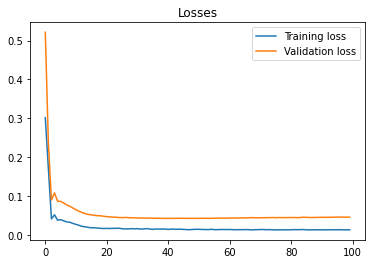

In [152]:
X_train_14, X_val_14, X_test_14, y_train_14, y_val_14, y_test_14 = train_val_test_split(df_generated_14, 'CANTIDAD', 0.1)

input_dim = len(X_train_14.columns)
model_params_14 = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

scaler = MinMaxScaler()

X_train_sc_14 = scaler.fit_transform(X_train_14)
X_val_sc_14 = scaler.transform(X_val_14)
X_test_sc_14 = scaler.transform(X_test_14)

y_train_sc_14 = scaler.fit_transform(y_train_14)
y_val_sc_14 = scaler.transform(y_val_14)
y_test_sc_14 = scaler.transform(y_test_14)

train_features_14 = torch.Tensor(X_train_sc_14)
train_targets_14 = torch.Tensor(y_train_sc_14)
val_features_14 = torch.Tensor(X_val_sc_14)
val_targets_14 = torch.Tensor(y_val_sc_14)
test_features_14 = torch.Tensor(X_test_sc_14)
test_targets_14 = torch.Tensor(y_test_sc_14)

train_14 = TensorDataset(train_features_14, train_targets_14)
val_14 = TensorDataset(val_features_14, val_targets_14)
test_14 = TensorDataset(test_features_14, test_targets_14)

train_loader_14 = DataLoader(train_14, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader_14 = DataLoader(val_14, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_14 = DataLoader(test_14, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one_14 = DataLoader(test_14, batch_size=1, shuffle=False, drop_last=True)

model = get_model('lstm', model_params_14)

loss_fn = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader_14, val_loader_14, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one_14,
    batch_size=1,
    n_features=input_dim
)

Text(0.5, 1.0, 'Prediccion con el dataset de Test')

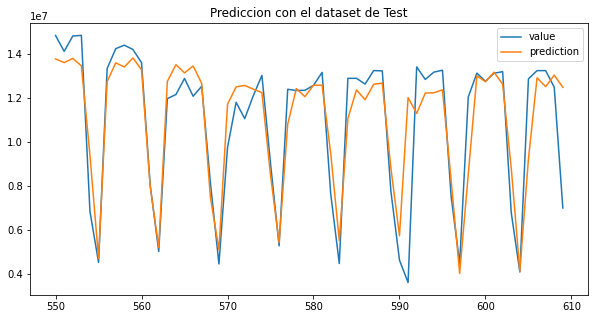

In [153]:
df_result_14 = format_predictions(predictions, values, X_test_14, scaler)
df_result_14.plot(figsize=[10,5])
plt.title("Prediccion con el dataset de Test")

In [154]:
result_metrics_14 = calculate_metrics(df_result_14)
result_metrics_14

{'mae': 1070282.0, 'rmse': 1732714.1338651336, 'r2': 0.7385178491136966}

Pruebo usando los ultimos 28 lags

In [30]:
df_generated_7 = generate_time_lags(serie_lstm, 28)
df_generated_7.drop(columns=["DIA_TRANSPORTE"], inplace=True)

X_train_7, X_val_7, X_test_7, y_train_7, y_val_7, y_test_7 = train_val_test_split(df_generated_7, 'CANTIDAD', 0.1)

In [32]:
X_train_7.shape, X_val_7.shape, X_test_7.shape, y_train_7.shape, y_val_7.shape, y_test_7.shape

((464, 28), (59, 28), (59, 28), (464, 1), (59, 1), (59, 1))

[1/100] Training loss: 0.2727	 Validation loss: 0.4750
[2/100] Training loss: 0.1509	 Validation loss: 0.1960
[3/100] Training loss: 0.0437	 Validation loss: 0.0883
[4/100] Training loss: 0.0501	 Validation loss: 0.1046
[5/100] Training loss: 0.0390	 Validation loss: 0.0848
[6/100] Training loss: 0.0395	 Validation loss: 0.0834
[7/100] Training loss: 0.0348	 Validation loss: 0.0757
[8/100] Training loss: 0.0306	 Validation loss: 0.0688
[9/100] Training loss: 0.0258	 Validation loss: 0.0618
[10/100] Training loss: 0.0226	 Validation loss: 0.0570
[50/100] Training loss: 0.0131	 Validation loss: 0.0405
[100/100] Training loss: 0.0118	 Validation loss: 0.0418


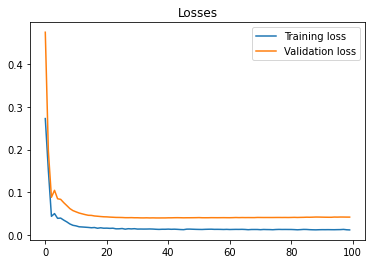

In [179]:
input_dim = len(X_train_7.columns)
model_params_7 = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

scaler = MinMaxScaler()

X_train_sc_7 = scaler.fit_transform(X_train_7)
X_val_sc_7 = scaler.transform(X_val_7)
X_test_sc_7 = scaler.transform(X_test_7)

y_train_sc_7 = scaler.fit_transform(y_train_7)
y_val_sc_7 = scaler.transform(y_val_7)
y_test_sc_7 = scaler.transform(y_test_7)

train_features_7 = torch.Tensor(X_train_sc_7)
train_targets_7 = torch.Tensor(y_train_sc_7)
val_features_7 = torch.Tensor(X_val_sc_7)
val_targets_7 = torch.Tensor(y_val_sc_7)
test_features_7 = torch.Tensor(X_test_sc_7)
test_targets_7 = torch.Tensor(y_test_sc_7)

train_7 = TensorDataset(train_features_7, train_targets_7)
val_7 = TensorDataset(val_features_7, val_targets_7)
test_7 = TensorDataset(test_features_7, test_targets_7)

train_loader_7 = DataLoader(train_7, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader_7 = DataLoader(val_7, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_7 = DataLoader(test_7, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one_7 = DataLoader(test_7, batch_size=1, shuffle=False, drop_last=True)

model = get_model('lstm', model_params_7)

loss_fn = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader_7, val_loader_7, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one_7,
    batch_size=1,
    n_features=input_dim
)

Text(0.5, 1.0, 'Prediccion con el dataset de Test')

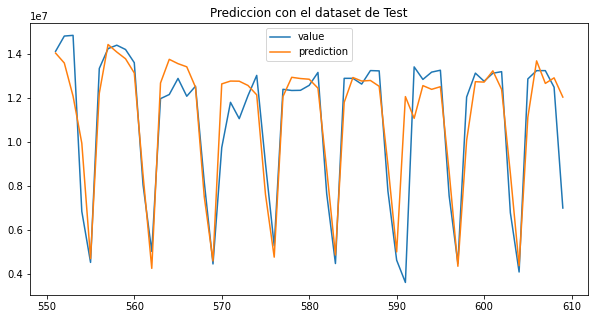

In [180]:
df_result_7 = format_predictions(predictions, values, X_test_7, scaler)
df_result_7.plot(figsize=[10,5])
plt.title("Prediccion con el dataset de Test")

In [181]:
result_metrics_7 = calculate_metrics(df_result_7)
result_metrics_7

{'mae': 1026805.0, 'rmse': 1676739.653265229, 'r2': 0.7535398851240398}

Pruebo agregando features

In [271]:
df_features = serie_lstm.copy()
df_features = (
                df_features
                .assign(day = df_features.DIA_TRANSPORTE.dt.day)
                .assign(month = df_features.DIA_TRANSPORTE.dt.month)
                .assign(year = df_features.DIA_TRANSPORTE.dt.year)
                .assign(day_of_week = df_features.DIA_TRANSPORTE.dt.dayofweek) 
              )
df_features.head()

DIA_TRANSPORTE  CANTIDAD  day  month  year  day_of_week
0     2021-01-01   1178259    1      1  2021            4
1     2021-01-02   3626837    2      1  2021            5
2     2021-01-03   2349540    3      1  2021            6
3     2021-01-04   6352559    4      1  2021            0
4     2021-01-05   6591339    5      1  2021            1

In [272]:
df_features["2021"] = df_features.year.apply(lambda x: 1 if x == 2021 else 0)
df_features["2022"] = df_features.year.apply(lambda x: 1 if x == 2022 else 0)
df_features["weekend"] = df_features.day_of_week.apply(lambda x: 1 if (x == 5 or x == 6) else 0)
df_features.drop(columns=["year"], inplace=True)
df_features

DIA_TRANSPORTE  CANTIDAD  day  month  day_of_week  2021  2022  weekend
0       2021-01-01   1178259    1      1            4     1     0        0
1       2021-01-02   3626837    2      1            5     1     0        1
2       2021-01-03   2349540    3      1            6     1     0        1
3       2021-01-04   6352559    4      1            0     1     0        0
4       2021-01-05   6591339    5      1            1     1     0        0
..             ...       ...  ...    ...          ...   ...   ...      ...
605     2022-08-29  12862451   29      8            0     0     1        0
606     2022-08-30  13239561   30      8            1     0     1        0
607     2022-08-31  13239636   31      8            2     0     1        0
608     2022-09-01  12483866    1      9            3     0     1        0
609     2022-09-02   6981899    2      9            4     0     1        0

[610 rows x 8 columns]

In [240]:
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

In [273]:
df_features = generate_cyclical_features(df_features, 'day', 31, 0)
df_features = generate_cyclical_features(df_features, 'day_of_week', 7, 0)
df_features = generate_cyclical_features(df_features, 'month', 12, 1)
df_features

DIA_TRANSPORTE  CANTIDAD  2021  2022  weekend       sin_day   cos_day  \
0       2021-01-01   1178259     1     0        0  2.012985e-01  0.979530   
1       2021-01-02   3626837     1     0        1  3.943559e-01  0.918958   
2       2021-01-03   2349540     1     0        1  5.712682e-01  0.820763   
3       2021-01-04   6352559     1     0        0  7.247928e-01  0.688967   
4       2021-01-05   6591339     1     0        0  8.486443e-01  0.528964   
..             ...       ...   ...   ...      ...           ...       ...   
605     2022-08-29  12862451     0     1        0 -3.943559e-01  0.918958   
606     2022-08-30  13239561     0     1        0 -2.012985e-01  0.979530   
607     2022-08-31  13239636     0     1        0 -2.449294e-16  1.000000   
608     2022-09-01  12483866     0     1        0  2.012985e-01  0.979530   
609     2022-09-02   6981899     0     1        0  3.943559e-01  0.918958   

     sin_day_of_week  cos_day_of_week  sin_month  cos_month  
0          -0.433884        -0.900969   0.000000   1.000000  
1          -0.974928        -0.222521   0.000000   1.000000  
2          -0.781831         0.623490   0.000000   1.000000  
3           0.000000         1.000000   0.000000   1.000000  
4           0.781831         0.623490   0.000000   1.000000  
..               ...              ...        ...        ...  
605         0.000000         1.000000  -0.500000  -0.866025  
606         0.781831         0.623490  -0.500000  -0.866025  
607         0.974928        -0.222521  -0.500000  -0.866025  
608         0.433884        -0.900969  -0.866025  -0.500000  
609        -0.433884        -0.900969  -0.866025  -0.500000  

[610 rows x 11 columns]

In [274]:
df_features.drop(['DIA_TRANSPORTE'], axis=1, inplace=True)

In [275]:
df_features_lags= generate_time_lags(df_features, 28)
df_features_lags

CANTIDAD  2021  2022  weekend       sin_day   cos_day  sin_day_of_week  \
28    6742553     1     0        0 -3.943559e-01  0.918958        -0.433884   
29    3929214     1     0        1 -2.012985e-01  0.979530        -0.974928   
30    2313557     1     0        1 -2.449294e-16  1.000000        -0.781831   
31    6202566     1     0        0  2.012985e-01  0.979530         0.000000   
32    6810353     1     0        0  3.943559e-01  0.918958         0.781831   
..        ...   ...   ...      ...           ...       ...              ...   
605  12862451     0     1        0 -3.943559e-01  0.918958         0.000000   
606  13239561     0     1        0 -2.012985e-01  0.979530         0.781831   
607  13239636     0     1        0 -2.449294e-16  1.000000         0.974928   
608  12483866     0     1        0  2.012985e-01  0.979530         0.433884   
609   6981899     0     1        0  3.943559e-01  0.918958        -0.433884   

     cos_day_of_week  sin_month  cos_month        lag1        lag2  \
28         -0.900969   0.000000   1.000000   6560781.0   6761265.0   
29         -0.222521   0.000000   1.000000   6742553.0   6560781.0   
30          0.623490   0.000000   1.000000   3929214.0   6742553.0   
31          1.000000   0.500000   0.866025   2313557.0   3929214.0   
32          0.623490   0.500000   0.866025   6202566.0   2313557.0   
..               ...        ...        ...         ...         ...   
605         1.000000  -0.500000  -0.866025   4068994.0   6769118.0   
606         0.623490  -0.500000  -0.866025  12862451.0   4068994.0   
607        -0.222521  -0.500000  -0.866025  13239561.0  12862451.0   
608        -0.900969  -0.866025  -0.500000  13239636.0  13239561.0   
609        -0.900969  -0.866025  -0.500000  12483866.0  13239636.0   

           lag3        lag4        lag5        lag6        lag7        lag8  \
28    6376674.0   6330082.0   2542015.0   4723921.0   7055363.0   6729614.0   
29    6761265.0   6376674.0   6330082.0   2542015.0   4723921.0   7055363.0   
30    6560781.0   6761265.0   6376674.0   6330082.0   2542015.0   4723921.0   
31    6742553.0   6560781.0   6761265.0   6376674.0   6330082.0   2542015.0   
32    3929214.0   6742553.0   6560781.0   6761265.0   6376674.0   6330082.0   
..          ...         ...         ...         ...         ...         ...   
605  13192809.0  13121347.0  12755757.0  13125474.0  12036539.0   4464674.0   
606   6769118.0  13192809.0  13121347.0  12755757.0  13125474.0  12036539.0   
607   4068994.0   6769118.0  13192809.0  13121347.0  12755757.0  13125474.0   
608  12862451.0   4068994.0   6769118.0  13192809.0  13121347.0  12755757.0   
609  13239561.0  12862451.0   4068994.0   6769118.0  13192809.0  13121347.0   

           lag9       lag10       lag11       lag12       lag13       lag14  \
28    6771665.0   6744079.0   6777421.0   2652005.0   4497750.0   6616257.0   
29    6729614.0   6771665.0   6744079.0   6777421.0   2652005.0   4497750.0   
30    7055363.0   6729614.0   6771665.0   6744079.0   6777421.0   2652005.0   
31    4723921.0   7055363.0   6729614.0   6771665.0   6744079.0   6777421.0   
32    2542015.0   4723921.0   7055363.0   6729614.0   6771665.0   6744079.0   
..          ...         ...         ...         ...         ...         ...   
605   7538089.0  13257733.0  13171714.0  12839330.0  13409558.0   3593133.0   
606   4464674.0   7538089.0  13257733.0  13171714.0  12839330.0  13409558.0   
607  12036539.0   4464674.0   7538089.0  13257733.0  13171714.0  12839330.0   
608  13125474.0  12036539.0   4464674.0   7538089.0  13257733.0  13171714.0   
609  12755757.0  13125474.0  12036539.0   4464674.0   7538089.0  13257733.0   

          lag15       lag16       lag17       lag18       lag19       lag20  \
28    6849803.0   6889261.0   6856011.0   5090755.0   2466528.0   4607956.0   
29    6616257.0   6849803.0   6889261.0   6856011.0   5090755.0   2466528.0   
30    4497750.0   6616257.0   6849803.0   6889261.0   6856011.0   5090755.0   
3

[1/100] Training loss: 0.2956	 Validation loss: 0.4799
[2/100] Training loss: 0.1186	 Validation loss: 0.1060
[3/100] Training loss: 0.0481	 Validation loss: 0.0878
[4/100] Training loss: 0.0445	 Validation loss: 0.0939
[5/100] Training loss: 0.0334	 Validation loss: 0.0735
[6/100] Training loss: 0.0307	 Validation loss: 0.0665
[7/100] Training loss: 0.0226	 Validation loss: 0.0551
[8/100] Training loss: 0.0179	 Validation loss: 0.0492
[9/100] Training loss: 0.0160	 Validation loss: 0.0472
[10/100] Training loss: 0.0151	 Validation loss: 0.0453
[50/100] Training loss: 0.0113	 Validation loss: 0.0395
[100/100] Training loss: 0.0111	 Validation loss: 0.0428


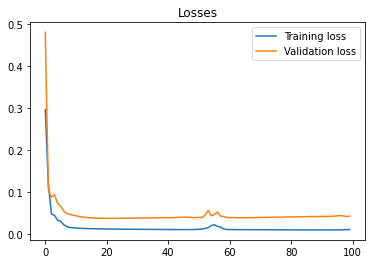

In [286]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_features_lags, 'CANTIDAD', 0.1)

scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

y_train_sc = scaler.fit_transform(y_train)
y_val_sc = scaler.transform(y_val)
y_test_sc = scaler.transform(y_test)

train_features = torch.Tensor(X_train_sc)
train_targets = torch.Tensor(y_train_sc)
val_features = torch.Tensor(X_val_sc)
val_targets = torch.Tensor(y_val_sc)
test_features = torch.Tensor(X_test_sc)
test_targets = torch.Tensor(y_test_sc)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
dropout = 0
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6
model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params)

loss_fn = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

Text(0.5, 1.0, 'Prediccion con el dataset de Test')

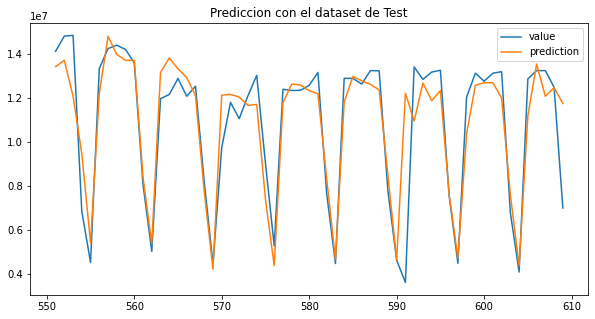

In [287]:
df_result = format_predictions(predictions, values, X_test, scaler)
df_result.plot(figsize=[10,5])
plt.title("Prediccion con el dataset de Test")

In [288]:
result_metrics = calculate_metrics(df_result)
result_metrics

{'mae': 987388.5, 'rmse': 1632806.9333708747, 'r2': 0.7662858265736145}

##### GRU

In [291]:
class GRUModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = torch.nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [292]:
def get_model(model, model_params):
    models = {
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

[1/55] Training loss: 0.1345	 Validation loss: 0.1278
[2/55] Training loss: 0.0780	 Validation loss: 0.1181
[3/55] Training loss: 0.0341	 Validation loss: 0.0731
[4/55] Training loss: 0.0353	 Validation loss: 0.0674
[5/55] Training loss: 0.0252	 Validation loss: 0.0575
[6/55] Training loss: 0.0200	 Validation loss: 0.0525
[7/55] Training loss: 0.0168	 Validation loss: 0.0494
[8/55] Training loss: 0.0168	 Validation loss: 0.0468
[9/55] Training loss: 0.0175	 Validation loss: 0.0461
[10/55] Training loss: 0.0165	 Validation loss: 0.0455
[50/55] Training loss: 0.0130	 Validation loss: 0.0396


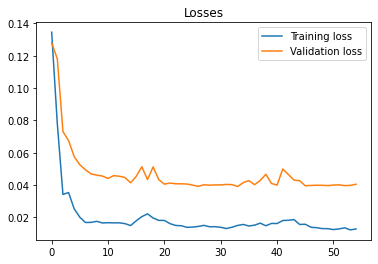

In [318]:
output_dim = 1
hidden_dim = 100
layer_dim = 3
dropout = 0.2
n_epochs = 55
learning_rate = 1e-3
weight_decay = 1e-6
model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('gru', model_params)

loss_fn = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

Text(0.5, 1.0, 'Prediccion con el dataset de Test')

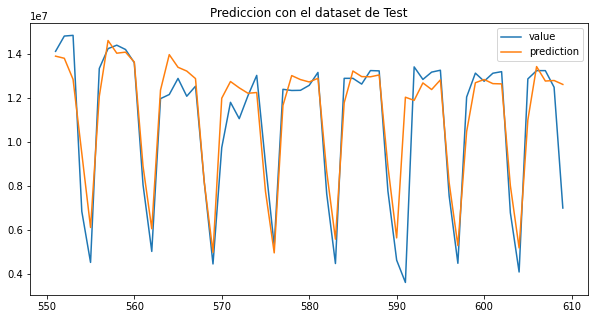

In [319]:
df_result = format_predictions(predictions, values, X_test, scaler)
df_result.plot(figsize=[10,5])
plt.title("Prediccion con el dataset de Test")

In [320]:
result_metrics = calculate_metrics(df_result)
result_metrics

{'mae': 997282.7, 'rmse': 1637664.9551162778, 'r2': 0.764893027020531}